# Introduction 
We set out to answer three questions: 
### How can the innovation level of a country in Europe be measured? 

### What characteristics of a country predict the innovation level?

### What characteristics of a country predict an increase or decrease in the innovation level?


When exploring the topic, after several rounds of research some possible existing answers like the GII turned up. We then decided to learn how it works, and do testing around it and its' components. 
Innovation is not a measurable statistic, and as such there can only be approximations at the hand of other, measurable values and inferences on how they might relate to innovation in a country. Will innovation lead to greater economic output? Will greater economic output lead to greater innovation? 

# Analysis of the Global Innovation Index (GII) by WIPO

Since innovation is not directly measurable, we needed to find a suitable "ground truth" for the innovation level of a country. There are a few approaches on how to do that, one of them is to consider research & development spendings or patent activity of countries. However, our decision was to take a more complex measurment, namely the Global Innovation Index (GII). This index includes around 80 different measures and calculates a single innovation score. This score is considered as ground truth in our further analysis.

Summary: https://www.wipo.int/web-publications/global-innovation-index-2024/en/index.html  
Dataset: https://www.wipo.int/publications/de/details.jsp?id=4756&plang=DE


## Download & Preprocess Data

In the following code cells, we download the data and preprocess it for further analysis. For our first analysis, we consider the last 4 years available and thus download this.

In [1]:
import wget
import os.path
import pandas as pd

filename = "../data/GII_2024.xlsx"
if not os.path.isfile(filename):
    url = "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2024-tech1.xlsx"
    filename = wget.download(url, out=filename)

GII_2024 = pd.read_excel(filename, sheet_name=None)



In [2]:
def download(filename, url):
    if not os.path.isfile(filename):
        filename = wget.download(url, out=filename)

filename_2023 = "../data/GII_2023.xlsx"
filename_2022 = "../data/GII_2022.xlsx"
filename_2021 = "../data/GII_2021.xlsx"
# filename_historical = "../data/GII_historical.xlsx"
download(filename_2023, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2023-tech1.xlsx")
download(filename_2022, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2022-tech1.xlsx")
download(filename_2021, "https://www.wipo.int/edocs/pubdocs/en/wipo_pub_2000-tech1.xlsx")


# import requests
# headers = {"User-Agent": "Mozilla/5.0"}
# response = requests.get("https://data.mendeley.com/public-files/datasets/cvkdzr8tv3/files/18c1e6f1-af82-4e51-97d8-ac9071cf4ae3/file_downloaded", headers=headers)
# with open(filename_historical, 'wb') as file:
#     file.write(response.content)


GII_2023 = pd.read_excel(filename_2023, sheet_name=None)
GII_2022 = pd.read_excel(filename_2022, sheet_name=None)
GII_2021 = pd.read_excel(filename_2021, sheet_name=None)

The following function provides a possibility to do some first preprocessing on our GII dataframe and extract information specific to European countries, as this is the area we are mainly focussing on in our analysis.

In [3]:
def get_europe(in_df, data_name = "Data", economies_name = "Economies", iso_name = "ISO3", economy_name_name = "ECONOMY_NAME", 
               reguncode_name = "REG_UN_CODE", regun_name = "REG_UN"):
    
    '''The get_europe function processes input data frames related to global innovation index (GII) data and extracts information specific to European countries'''
    
    gii_data = in_df[data_name]
    #display(gii_data)
    gii_economies = in_df[economies_name]
    #display(gii_economies)
    
    joined = gii_data.merge(gii_economies, on=iso_name, suffixes=["", "_joined_r"]).drop(columns=economy_name_name + "_joined_r")
    #display(joined)

    gii_data_eu = joined[joined[reguncode_name] == "EUR"].drop(columns=[regun_name, reguncode_name])
    #display(gii_data_eu)
    return gii_data_eu

    
    
    

In [4]:

dfs = GII_2024
gii_data_eu_2024 = (get_europe(dfs))
name_map = gii_data_eu_2024.set_index("NUM")["NAME"].to_dict()


In [5]:
#name_map

After our first steps of preprocessing, we want to have a first look into our data. The following table shows an overview of the scores for single European countries and their innovation score and rank.

In [6]:
def get_display_data():
    pure_rank = gii_data_eu_2024[gii_data_eu_2024["NUM"].isnull()]
    display_data = pure_rank.sort_values("RANK")[["RANK", "ECONOMY_NAME", "SCORE"]]
    display_data.rename(columns={"RANK": "GLOBAL_RANK"}, inplace=True)
    display_data.index = range(1, len(display_data) + 1)
    return display_data

display_data = get_display_data()

display(display_data)

,GLOBAL_RANK,ECONOMY_NAME,SCORE
1,1.0,Switzerland,67.473082
2,2.0,Sweden,64.524365
3,5.0,United Kingdom,61.049318
4,7.0,Finland,59.436931
5,8.0,Netherlands (Kingdom of the),58.833036
6,9.0,Germany,58.082837
7,10.0,Denmark,57.114019
8,12.0,France,55.413323
9,16.0,Estonia,52.307935
10,17.0,Austria,50.276568


Get all the scores in a nice format

In [7]:
def get_nice_table(gii_data_eu):
    gii_data_eu["NUM"] = gii_data_eu["NUM"].fillna("Final")
    df_scores = gii_data_eu.pivot_table(index='ECONOMY_NAME', columns='NUM', values='SCORE')
    df_scores.head()
    return gii_data_eu, df_scores

gii_data_eu_2024, df_scores = get_nice_table(gii_data_eu_2024)
#df_scores.head()

Next, we will have a look on NaN values.

In [8]:
print(len(df_scores))
nans = df_scores.isna().sum()
nans[nans > 5]

#ToDo: Wir haben Nanvalues was machen wir damit? Weil wenn wir sie ignorieren, sollten wir sie vielleicht nicht vorher plotten.

39


NUM
IN.1.3.2      8
IN.2.1.2      6
IN.4.1.1      8
IN.4.1.3     28
IN.4.2.1     13
IN.4.2.2      6
OUT.6.1.3    15
OUT.7.1.1     7
OUT.7.2.3    18
dtype: int64

Keep only raw values

In [9]:
def get_raw_data_index_structure(in_df:pd.DataFrame):
    gii_index_structure = in_df["Index Structure"]
    gii_index_structure = gii_index_structure.set_index("NUM")

    indicators = gii_index_structure[gii_index_structure["LEVEL"] == "Indicator"].index.tolist()

    df_scores_raw = df_scores[indicators]
    df_scores_raw.head()
    return df_scores_raw, gii_index_structure

df_scores_raw_2024, gii_index_structure_2024 = get_raw_data_index_structure(dfs)


## Plots

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

### Correlation

In this step we cacluate the correlation matrix between different indicators of the GII and additional the GII score itself. 
Our hypothesis is that some indicators are more important than others and that they are correlated with the GII score. So in essence we want to find out which indicators are the most important/representative for the overall GII score.

#### Cross Correlation between Indicators

In this step we calculate the cross correlation between each indicator of the GII. (GII data 2024)

NUM,IN.1.1.1,IN.1.1.2,IN.1.2.1,IN.1.2.2,IN.1.3.1,IN.1.3.2,IN.2.1.1,IN.2.1.2,IN.2.1.3,IN.2.1.4,...,OUT.7.1.2,OUT.7.1.3,OUT.7.1.4,OUT.7.2.1,OUT.7.2.2,OUT.7.2.3,OUT.7.2.4,OUT.7.3.1,OUT.7.3.2,OUT.7.3.3
ECONOMY_NAME,,,,,,,,,,,,,,,,,,,,,
Albania,64.666667,45.682023,46.021116,39.082407,53.239174,NaN,19.749012,8.707010,55.805005,12.457062,...,19.538857,0.000000,3.206397,29.215047,21.091546,NaN,0.015020,4.665280,7.911415,55.113264
Austria,78.666667,82.256480,75.540934,92.758028,70.866482,48.241118,45.563688,46.026280,69.277034,61.622324,...,31.062763,31.316382,36.704423,28.107431,32.448332,55.611627,10.936722,46.679025,58.186882,70.088544
Belarus,29.333333,21.754110,6.868692,8.804238,NaN,4.854739,50.826906,NaN,52.179438,55.823408,...,12.053508,0.000000,10.250219,7.100597,NaN,NaN,11.007627,3.460304,23.282173,85.125199
Belgium,76.000000,76.045990,74.746506,82.522428,62.434239,NaN,63.862333,44.715117,87.753007,61.618671,...,19.155919,18.545688,18.006148,30.686072,30.577950,45.130785,10.008132,38.201565,64.610092,62.458527
Bosnia and Herzegovina,50.666667,16.182714,37.695356,35.041424,13.040617,27.233264,NaN,59.967872,47.131195,26.977543,...,8.957737,0.000000,9.085190,6.895249,23.838727,NaN,4.341885,2.941635,9.703905,47.190552
Bulgaria,64.000000,36.910167,50.258817,40.762039,33.066728,26.082768,39.389099,44.379929,51.366092,31.771123,...,50.814891,0.000000,63.124396,55.396575,32.148463,NaN,12.479030,12.527101,33.229753,70.880306
Croatia,78.000000,59.173956,55.035772,54.393755,24.890957,5.346422,50.993668,NaN,63.581771,56.424219,...,23.405884,0.847986,25.547276,43.269513,20.210425,NaN,8.850087,13.114606,30.036111,69.659817
Czech Republic,78.666667,72.552756,78.238495,75.406228,49.940715,NaN,49.075847,47.946003,69.132425,63.609330,...,31.850284,8.156953,22.559831,21.764565,68.032945,24.746470,100.000000,33.999568,65.441337,74.621690
Denmark,89.333333,95.972277,90.248434,98.334799,79.291556,NaN,60.293178,40.941808,86.020769,63.408659,...,16.928998,59.403841,36.415745,20.354546,28.757248,68.289651,17.919104,65.478399,76.798360,75.400848


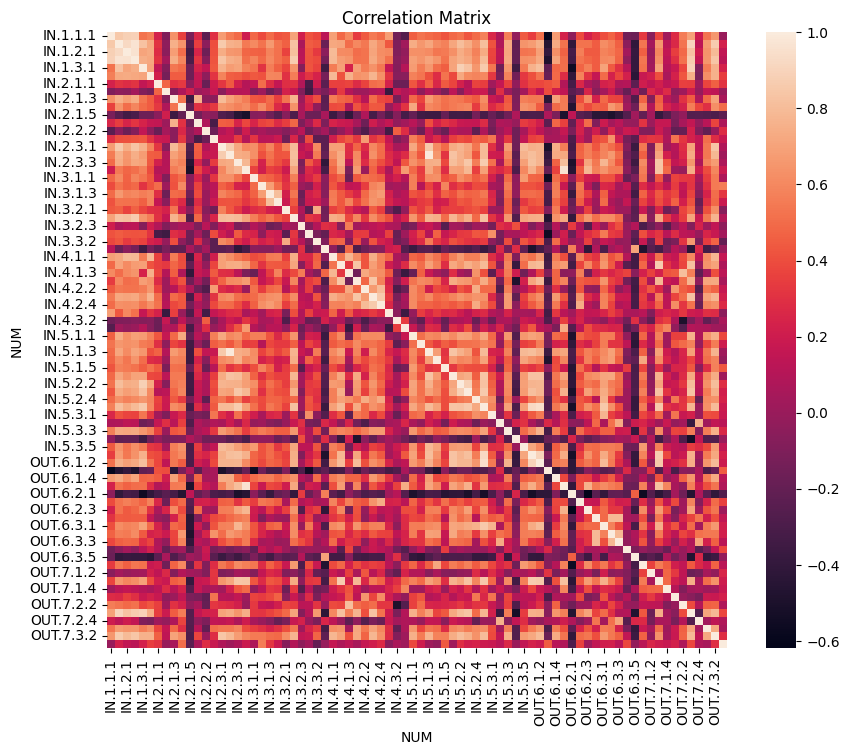

In [11]:
def get_corr_matrix(df_scores_raw):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_scores_raw.corr(),)
    plt.title("Correlation Matrix")
    plt.show()

display(df_scores_raw_2024)

get_corr_matrix(df_scores_raw_2024)


From the Crosscorrelation matrix above we can extract pairs with high correlation. It makes sense that some indicators in a pillar are correlated (depict similar information). But it is also interesting to see if there are indicators from different pillars that are correlated. This could indicate that the pillars are not independent from each other.

In [12]:
raw_corr = df_scores_raw_2024.corr()
c_rate = 0.8
high_corr = raw_corr[abs(raw_corr) > c_rate]

In [13]:
high_corr_pairs = []
for i in range(len(raw_corr.columns)):
    for j in range(i+1, len(raw_corr.columns)):
        if abs(raw_corr.iloc[i,j]) > c_rate:
            high_corr_pairs.append({
                'Feature 1': raw_corr.index[i],
                'Feature 2': raw_corr.columns[j],
                'Correlation': raw_corr.iloc[i,j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)

high_corr_df['Correlation'] = high_corr_df['Correlation'].round(3)

print(high_corr_df)

    Feature 1  Feature 2  Correlation
0    IN.1.1.1   IN.1.1.2        0.852
1    IN.1.1.1   IN.1.2.1        0.885
2    IN.1.1.1   IN.1.2.2        0.892
3    IN.1.1.2   IN.1.2.1        0.921
4    IN.1.1.2   IN.1.2.2        0.965
..        ...        ...          ...
68   IN.5.2.5  OUT.7.3.2        0.803
69  OUT.6.1.1  OUT.6.1.2        0.894
70  OUT.6.1.1  OUT.7.1.3        0.864
71  OUT.6.1.2  OUT.7.1.3        0.849
72  OUT.6.1.5  OUT.7.1.3        0.821

[73 rows x 3 columns]


In [14]:
import itertools
import pandas as pd
import math
#naive "clustering"
def find_high_correlation_clusters(raw_corr, c_rate):
    clusters = []

    # find clusters where all of them are above a set rate. not sure if this is the smartest way to do it
    for r in range(4,5):
        print("r= " + str(r))
        #get permutations
        for combo in itertools.combinations(raw_corr.columns, r):
            # iterate over all pairs of two, check if correlation > the c_rate, if not -> no longer a valid cluster
            valid_cluster = True
            for pair in itertools.combinations(combo, 2):
                corr = raw_corr.loc[pair[0], pair[1]]
                if abs(corr) <= c_rate:
                    valid_cluster = False
                    break

            if valid_cluster:
                clusters.append(combo)

    return clusters

c_rate = 0.8
clusters = find_high_correlation_clusters(raw_corr, c_rate)








r= 4


In [15]:
# Display clusters
for i, cluster in enumerate(clusters):
    #print(f"Cluster {i+1}: {cluster}")
    print(f"Cluster {i+1}: ")
    for value in cluster:
        print(name_map[value])

Cluster 1: 
Operational stability for businesses*
Government effectiveness*
Regulatory quality*
Rule of law*
Cluster 2: 
Government effectiveness*
Regulatory quality*
Rule of law*
Logistics performance*
Cluster 3: 
Government effectiveness*
Regulatory quality*
Rule of law*
Entertainment and media market/th pop. 15–69
Cluster 4: 
Government effectiveness*
Rule of law*
Researchers, FTE/mn pop.
Logistics performance*
Cluster 5: 
Government effectiveness*
Rule of law*
Researchers, FTE/mn pop.
GitHub commits/mn pop. 15–69
Cluster 6: 
Government effectiveness*
Policy stability for doing business†
University–industry R&D collaboration†
Patent families/bn PPP$ GDP
Cluster 7: 
Government effectiveness*
Policy stability for doing business†
University–industry R&D collaboration†
Entertainment and media market/th pop. 15–69
Cluster 8: 
Government effectiveness*
University–industry R&D collaboration†
Patent families/bn PPP$ GDP
GitHub commits/mn pop. 15–69
Cluster 9: 
Policy stability for doing bus

#### Correlation between Indicators and GII Score

Since one of our main research questions is how to measure innovation levels of countries, we do not only want to consider the GII score, but we also want to find if there are easier/more slim ways to measure that. For that reason, we calculate the correlation between each indicator and the final GII score. The idea is that even though the single features are a part of the overall innovation score and thus implicitly have a certain degree of correlation with the final score, the contribution of single features is due to the 80 features considered in total just of small magnitude. That means a single feature does not contribute enough to generate a high correlation with the final score, but a high correlation rather indicates whether this feature is generally a good indicator for the innovation level of a country. So, now we will have a look on the top 10 features with the highest correlation with the final score.

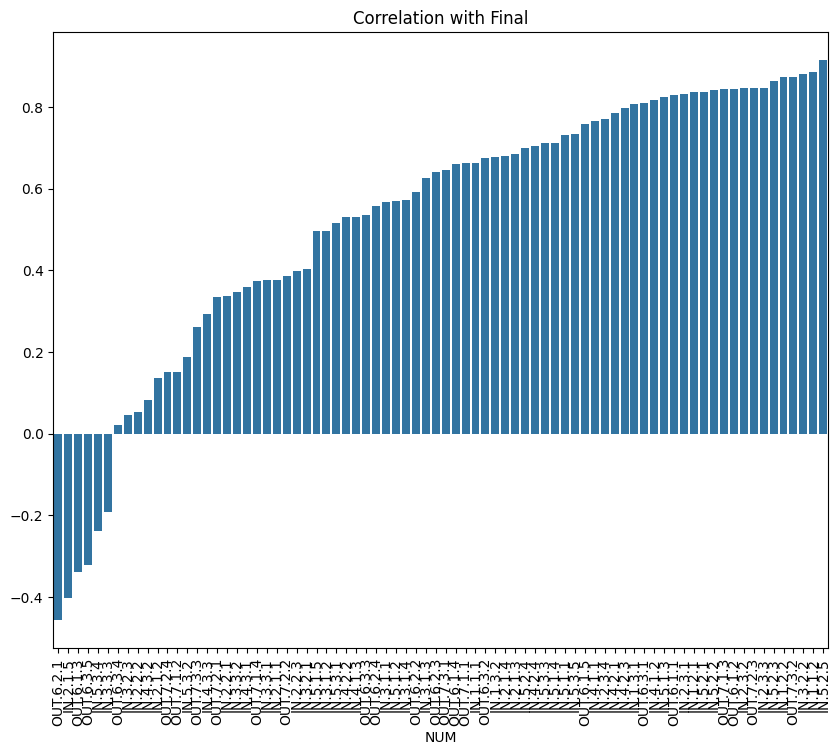

,NAME,DESCRIPTION,corr_w_final
NUM,,,
IN.1.1.2,Government effectiveness*,Index that reflects perceptions of the quality...,0.884958
IN.3.2.2,Logistics performance*,A multidimensional assessment of logistics per...,0.881405
OUT.7.3.2,GitHub commits/mn pop. 15–69,GitHub is the world’s largest host of source c...,0.874284
IN.1.2.2,Rule of law*,Index that reflects perceptions of the extent ...,0.873435
IN.5.2.3,State of cluster development†,Average answer to the survey question: In your...,0.862144
IN.2.3.3,"Global corporate R&D investors, top 3, mn USD",Average expenditure on R&D of the top three gl...,0.846993
OUT.7.2.3,Entertainment and media market/th pop. 15–69,'The Global Telecom and Entertainment & Media ...,0.846177
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.845228
OUT.6.1.2,PCT patents by origin/bn PPP$ GDP,A PCT application refers to an international p...,0.844857


In [16]:
def get_correlation_final(df_scores_raw, df_scores):
    corr_with_final = df_scores_raw.corrwith(df_scores["Final"])

    plt.figure(figsize=(10, 8))
    g = sns.barplot(corr_with_final.sort_values(),)
    g.tick_params(axis='x', rotation=90)
    plt.title("Correlation with Final")
    plt.show()
    corr_top10 = abs(corr_with_final).sort_values(ascending=False).iloc[1:11]

    corr_top10_info = gii_index_structure_2024.loc[corr_top10.index.to_list()][["NAME", "DESCRIPTION"]]
    corr_top10_info["corr_w_final"] = corr_top10
    display(corr_top10_info)

get_correlation_final(df_scores_raw_2024, df_scores)

We can see that the highest correlation is between Government effectiveness but among others there is also Gross expenditure on R&D or Patents by origin are highly correlating with the final score. This two features are often referred to as "measures" of innovation levels of countries in general (as stated already in the beginning). However, we decided against using them as "ground truth" in the beginning, even though it turns out, that both might be quite good representative for the overall innovation levels. 



To confirm our assumption, we will also have a look on the data of 2023.

NUM,Final,IN.1.1.1,IN.1.1.2,IN.1.2.1,IN.1.2.2,IN.1.2.3,IN.1.3.1,IN.1.3.2,IN.2.1.1,IN.2.1.2,...,OUT.7.1.3,OUT.7.1.4,OUT.7.2.1,OUT.7.2.2,OUT.7.2.3,OUT.7.2.4,OUT.7.3.1,OUT.7.3.2,OUT.7.3.3,OUT.7.3.4
ECONOMY_NAME,,,,,,,,,,,,,,,,,,,,,
Albania,25.426758,52.777778,36.651440,47.102852,32.218405,74.603170,53.954953,NaN,21.385565,9.648313,...,0.000000,22.694029,27.476446,18.342725,NaN,0.447837,7.741508,3.771317,6.029725,55.618992
Austria,53.247123,72.222222,80.083817,77.101802,92.095958,100.000000,82.381093,51.480605,45.189719,43.837719,...,27.255222,54.866511,22.636486,49.409297,63.164926,14.123925,42.107159,68.236516,50.738715,71.040723
Belarus,26.843908,35.416667,15.466163,18.245015,7.494473,72.937295,NaN,4.519599,38.666950,NaN,...,0.000000,24.121034,8.100193,NaN,NaN,10.207383,1.973795,6.564798,24.203359,88.386522
Belgium,49.943794,69.444444,67.802012,76.940038,78.560653,76.897685,66.105904,51.643961,59.419361,39.246380,...,17.451351,33.098651,25.620989,21.352796,50.507709,10.344550,24.665911,63.684251,57.907580,61.864579
Bosnia and Herzegovina,27.148722,41.666667,8.000920,37.464880,31.550794,97.579759,11.226345,26.082013,NaN,61.455524,...,0.000000,18.293905,8.214390,23.867938,NaN,4.289960,3.383727,3.346740,7.018992,47.214588
Bulgaria,38.983933,53.472222,32.902192,53.735132,38.433751,98.774164,38.509407,27.496616,32.189920,39.053988,...,0.000000,49.535792,35.391919,26.436956,NaN,12.153309,28.393305,4.573171,27.948082,71.246694
Croatia,37.070583,69.444444,53.059774,55.128433,48.582797,85.918593,26.505267,1.017713,28.553388,NaN,...,0.761890,43.100161,35.403925,13.195547,NaN,10.132478,17.712134,12.824891,26.252244,70.768487
Czech Republic,44.833748,72.222222,67.392403,77.096638,72.703832,75.797572,45.888937,NaN,36.589477,47.501826,...,5.834382,38.595196,13.112512,40.194607,27.240408,100.000000,20.576460,59.116199,58.016614,74.755815
Denmark,58.733405,85.416667,92.066035,89.042571,96.443001,78.657863,77.205744,NaN,66.749240,37.205424,...,51.651933,54.493039,18.458265,36.488374,77.840740,18.759812,56.787779,100.000000,64.700137,76.415224


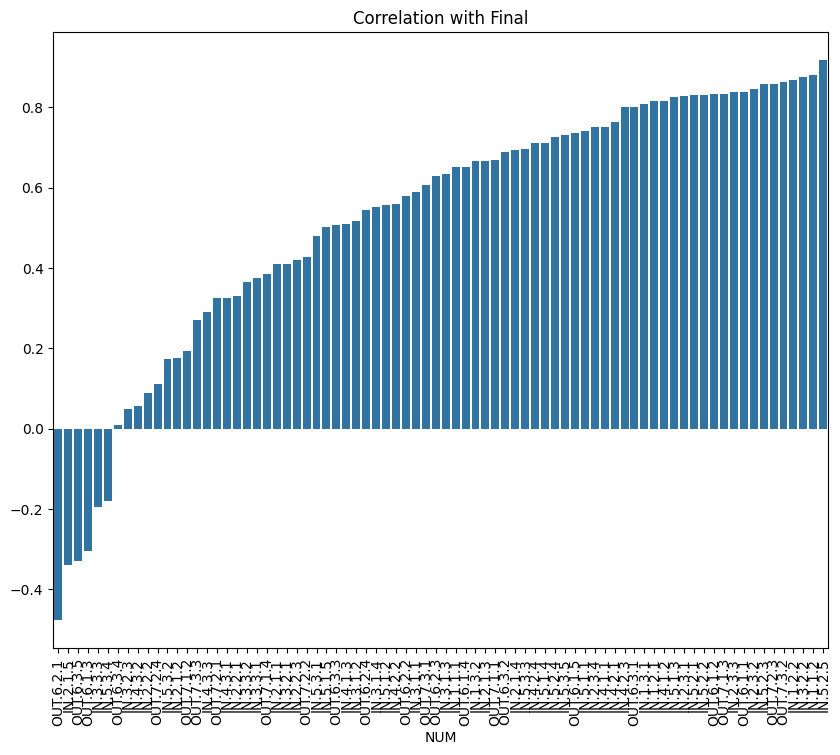

,NAME,DESCRIPTION,corr_w_final
NUM,,,
IN.1.1.2,Government effectiveness*,Index that reflects perceptions of the quality...,0.881114
IN.3.2.2,Logistics performance*,A multidimensional assessment of logistics per...,0.875101
IN.1.2.2,Rule of law*,Index that reflects perceptions of the extent ...,0.867391
OUT.7.3.2,GitHub commits/mn pop. 15–69,GitHub is the world’s largest host of source c...,0.863436
OUT.7.2.3,Entertainment and media market/th pop. 15–69,'The Global Telecom and Entertainment & Media ...,0.858175
IN.5.2.3,State of cluster development†,Average answer to the survey question: In your...,0.857972
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.846605
OUT.6.1.1,Patents by origin/bn PPP$ GDP,The definition of a patent can be found in the...,0.838237
IN.2.3.3,"Global corporate R&D investors, top 3, mn USD",Average expenditure on R&D of the top three gl...,0.837931


In [17]:
gii_data_eu_2023 = get_europe(GII_2023)

gii_data_eu_2023, df_scores_2023 = get_nice_table(gii_data_eu_2023)
df_scores_raw_2023, gii_index_structure_2023 = get_raw_data_index_structure(dfs)
gii_index_structure_2023 = GII_2023["Index Structure"]
gii_index_structure_2023 = gii_index_structure_2023.set_index("NUM")

indicators_2023 = ['Final']
indicators_2023.extend(gii_index_structure_2023[gii_index_structure_2023["LEVEL"] == "Indicator"].index.tolist())

GII_2023_prepared = df_scores_2023[indicators_2023]
display(GII_2023_prepared)
#get_corr_matrix(df_scores_raw)
get_correlation_final(df_scores_raw_2023, df_scores_2023)

Looking at the top 10 indicators for the GII 2023 data they are similar to the GII 2024 data but not the same. This could giving us an indication that the GII score is not stable dependant on these indicators. However, R&D spending and Patent activity is again highly correlating with the final score. 

This finding is already quite valuable for us, because we get a very easily and objectively measurable feature that is available for a long period without having a lot of changes in calculation. The issue with the GII is that the calculation formula adapted over the years and is not as good available as other features.

This is the reason, why we favour R&D expenditure in the further analysis. We consider R&D spending as one single features that is well suited to measure the innovation level of a country.

#TODO: brauchen wir das wirklich? würd ich wegkicken?
2024 from top copied
IN.1.1.2	Government effectiveness*	Index that reflects perceptions of the quality...	0.884958
IN.3.2.2	Logistics performance*	A multidimensional assessment of logistics per...	0.881405
OUT.7.3.2	GitHub commits/mn pop. 15–69	GitHub is the world’s largest host of source c...	0.874284
IN.1.2.2	Rule of law*	Index that reflects perceptions of the extent ...	0.873435
IN.5.2.3	State of cluster development†	Average answer to the survey question: In your...	0.862144
IN.2.3.3	Global corporate R&D investors, top 3, mn USD	Average expenditure on R&D of the top three gl...	0.846993
OUT.7.2.3	Entertainment and media market/th pop. 15–69	'The Global Telecom and Entertainment & Media ...	0.846177
IN.2.3.2	Gross expenditure on R&D, % GDP	Gross expenditure on R&D (GERD) is the total d...	0.845228
OUT.6.1.2	PCT patents by origin/bn PPP$ GDP	A PCT application refers to an international p...	0.844857
OUT.7.1.3

## Predictors
After we already identified a single feature that is quite suitable to measure the innovation level of a country, we wanted to dig a bit deeper and find a subset of features with even more explanatory power of our groundtruth. The reason for that is to again provide a simplification of the GII score, which is stronger than just a single factor like the R&D spendings.

### Finding predictors for future innovation level

In this step we want to find out which subset of indicators are the best predictors for the GII score. We will use a linear regression model with lasso to predict the GII score from the indicators. #TODO: Hä das versteh ich honestly gar nicht? Wir predicten da ja gar nix oder?

In [18]:
import sklearn
import numpy as np

## Feature Importance

In this step we look at how a common feature importance rating would select feature importances amongst the input variables.
The expectation is that since many of them are correlated in groups, one per group will be selected by the GradientBoostingRegressor.
When dealing with perfectly collinear features, GradientBoostingRegressor does not give identical features equal contribution weights. Instead, it may assign different importance values to features that are essentially providing the same information.

### Interpretability
The feature importance rankings commonly output by regression models have some shortcomings, and should not be taken at face value. They try to take into account correlations between the features, and not pick heavily correlated features as "important" together. So when interpreting these results, this should be taken into account. The selected features do matter, but the inverse, that the not selected ones do not is not necessarily true.

If you were to make a prediction model based on few features, you should choose these. However, for simplicity's and data availability's sake, we've chosen to continue with R&D Spending, since it has a high enough correlation with the output.


In [19]:
from sklearn.svm import LinearSVR
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer


from sklearn.feature_selection import SelectFromModel
y = df_scores["Final"]
#X = df_scores_raw.drop(columns="Final")
X = df_scores_raw_2024
#X.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
imputer = SimpleImputer(strategy='mean')
#simple imputation
X_imputed = imputer.fit_transform(X)
if np.isnan(X_imputed).any():
    raise ValueError("There are still NaN values in X_imputed after imputation")

Checking if there still are missing values after the simple imputation

In [20]:
pd.DataFrame(X_imputed).isna().any().sum()

np.int64(0)

In [21]:

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_imputed,y)
importances = reg.feature_importances_



In [22]:
importances_df = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
#importances_df.plot(kind='bar', figsize=(10, 8))

In [23]:
importances_df.head()

,Importance
NUM,
IN.1.1.1,0.001264
IN.1.1.2,0.078586
IN.1.2.1,0.000000
IN.1.2.2,0.015815
IN.1.3.1,0.080496


<Figure size 1000x600 with 0 Axes>

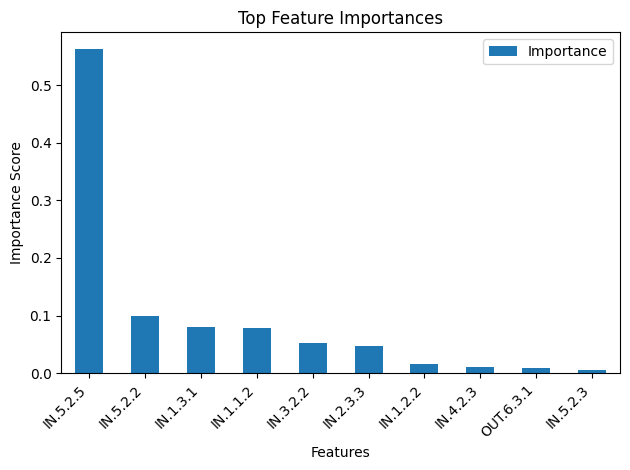

In [24]:

N = 10  
top_features = importances_df.sort_values('Importance', ascending=False).head(N)


plt.figure(figsize=(10, 6))
ax = top_features.plot(kind='bar')
plt.title('Top Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

As we can see in this condensed graph of the top 10 selected features by calculated importance, the importances that come out of a GradientBoostingRegressor appear to be heavily skewed towards IN 5.2.5, Patent families/bn PPP$ GDP.

# Eurostat Data Data Exploration

In the previous steps, we found out that R&D spendings and Patent activity are suitable measures for the innovation level. Thus, in this section we will use Eurostat data to gather this features for a longer period of time than we could get GII data. 

## R&D Expenditure
In the first part we will look at the R&D expenditure of the EU countries.


### Download & Preprocess Data
The following code cells are mainly used for preprocessing the Eurostat data.


In [25]:
import pycountry
import pycountry_convert as pc
def filterEuropeanCountries(iso2Name):
    try:
    
        
        # Convert the country alpha_2 code to continent code
        continent_code = pc.country_alpha2_to_continent_code(iso2Name)
        # Check if the continent code corresponds to Europe
        if continent_code == 'EU':
            return True
        return False
    except Exception as e:
        #print(f"Error: {e}")
        return False
# dont ask why i made two functions :) i know
def filterEuropeanCountriesISO3(iso3Name):
    try:
        # Convert the country alpha_2 code to continent code
        continent_code = pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(iso3Name))
        
        # Check if the continent code corresponds to Europe
        if continent_code == 'EU':
            return True
        return False
    except Exception as e:
        #print(f"Error: {e}")
        return False

In [26]:
import eurostat

# Dataset 	GERD by sector of performance and socioeconomic objectives rd_e_gerdsobj92
# sectperf: TOTAL All sectors
# sectperf: BES Business enterprise sector
# sectperf: GVT Government sector
# sectperf: HES Higher education sector
# sectperf: PNP Private non-profit sector

# unit = unit of measure
# EUR_HAB = Euro per inhabitant
# MIO_EUR = Million Euro
# MIO_PPS = Million Purchasing Power Standard
# MIO_PPS_KP05 = Million Purchasing Power Standard per capita, 2005 prices

# geo = country
# EU27_2020 = European Union (27 countries)
# EA20 = Euro area (20 countries)

# Available flags:
# (e) estimated
# (p) provisional
# (d) definition differs (see metadata)
# (bd) break in time series, definition differs (see metadata)
# (b) break in time series
# (de) definition differs (see metadata), estimated
# (dp) definition differs (see metadata), provisional
# (ep) estimated, provisional
# (bp) break in time series, provisional
# (u) low reliability


RD_EXP_BY_SECTOR = eurostat.get_data_df("rd_e_gerdtot", True)
print(RD_EXP_BY_SECTOR.head())

#filter(keep) only european countries so where geo\TIME_PERIOD filterEuropeanCountries == TRUE
RD_EXP_BY_SECTOR = RD_EXP_BY_SECTOR[RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]

print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())

countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()

# Patent applications https://ec.europa.eu/eurostat/databrowser/view/pat_ep_ntot/default/table?lang=en&category=scitech.ipr.pat.pat_h
PAT_APPLICATIONS_HIST = eurostat.get_data_df("pat_ep_ntot", True)
PAT_APPLICATIONS_NEW = eurostat.get_data_df("pat_ep_tot", True)

print(PAT_APPLICATIONS_HIST.head())

<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:39: SyntaxWarning: invalid escape sequence '\T'
<>:41: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:39: SyntaxWarning: invalid escape sequence '\T'
<>:41: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/787064550.py:37: SyntaxWarning: invalid escape sequence '\T'
  RD_EXP_BY_SECTOR = RD_EXP_BY_SECTOR[RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]
/tmp/ipykernel_262139/787064550.py:39: SyntaxWarning: invalid escape sequence '\T'
  print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())
/tmp/ipykernel_262139/787064550.py:41: SyntaxWarning: invalid escape sequence '\T'
  countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()


  freq sectperf     unit geo\TIME_PERIOD  1980_value 1980_flag  1981_value  \
0    A      BES  EUR_HAB              AT         NaN         :      51.466   
1    A      BES  EUR_HAB              BA         NaN         :         NaN   
2    A      BES  EUR_HAB              BE         NaN         :      92.121   
3    A      BES  EUR_HAB              BG         NaN         :         NaN   
4    A      BES  EUR_HAB              CH         NaN         :     226.259   

  1981_flag  1982_value 1982_flag  ...  2019_value 2019_flag  2020_value  \
0         d         NaN         :  ...     987.624               953.084   
1         :         NaN         :  ...       3.419                 3.630   
2                95.968            ...     972.758              1001.321   
3         :         NaN         :  ...      51.644                53.788   
4                   NaN         :  ...    1629.766                   NaN   

  2020_flag  2021_value 2021_flag  2022_value 2022_flag  2023_value 2023_f

Add a variable to check for time specific timespan.
Per county of origin.


<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/3019163643.py:20: SyntaxWarning: invalid escape sequence '\T'
  country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
/tmp/ipykernel_262139/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)
/tmp/ipykernel_262139/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)
/tmp/ipykernel_262139/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)


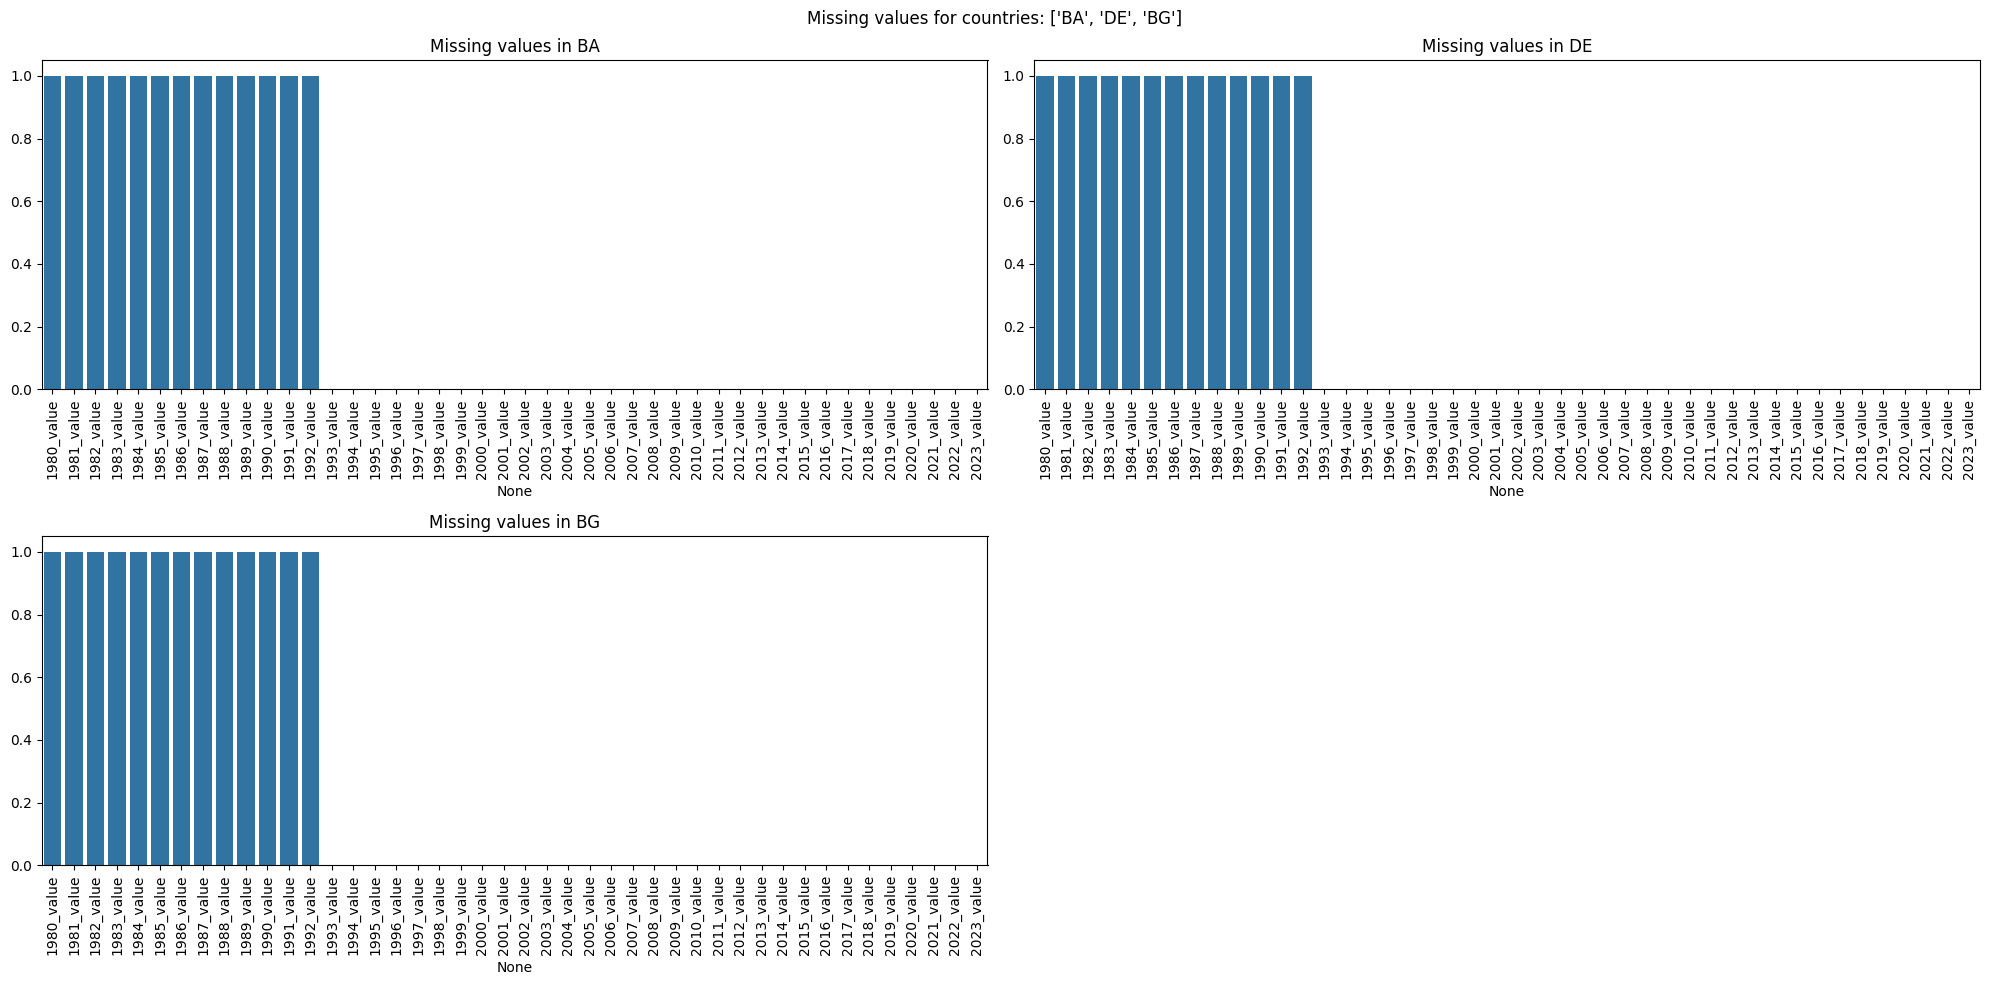

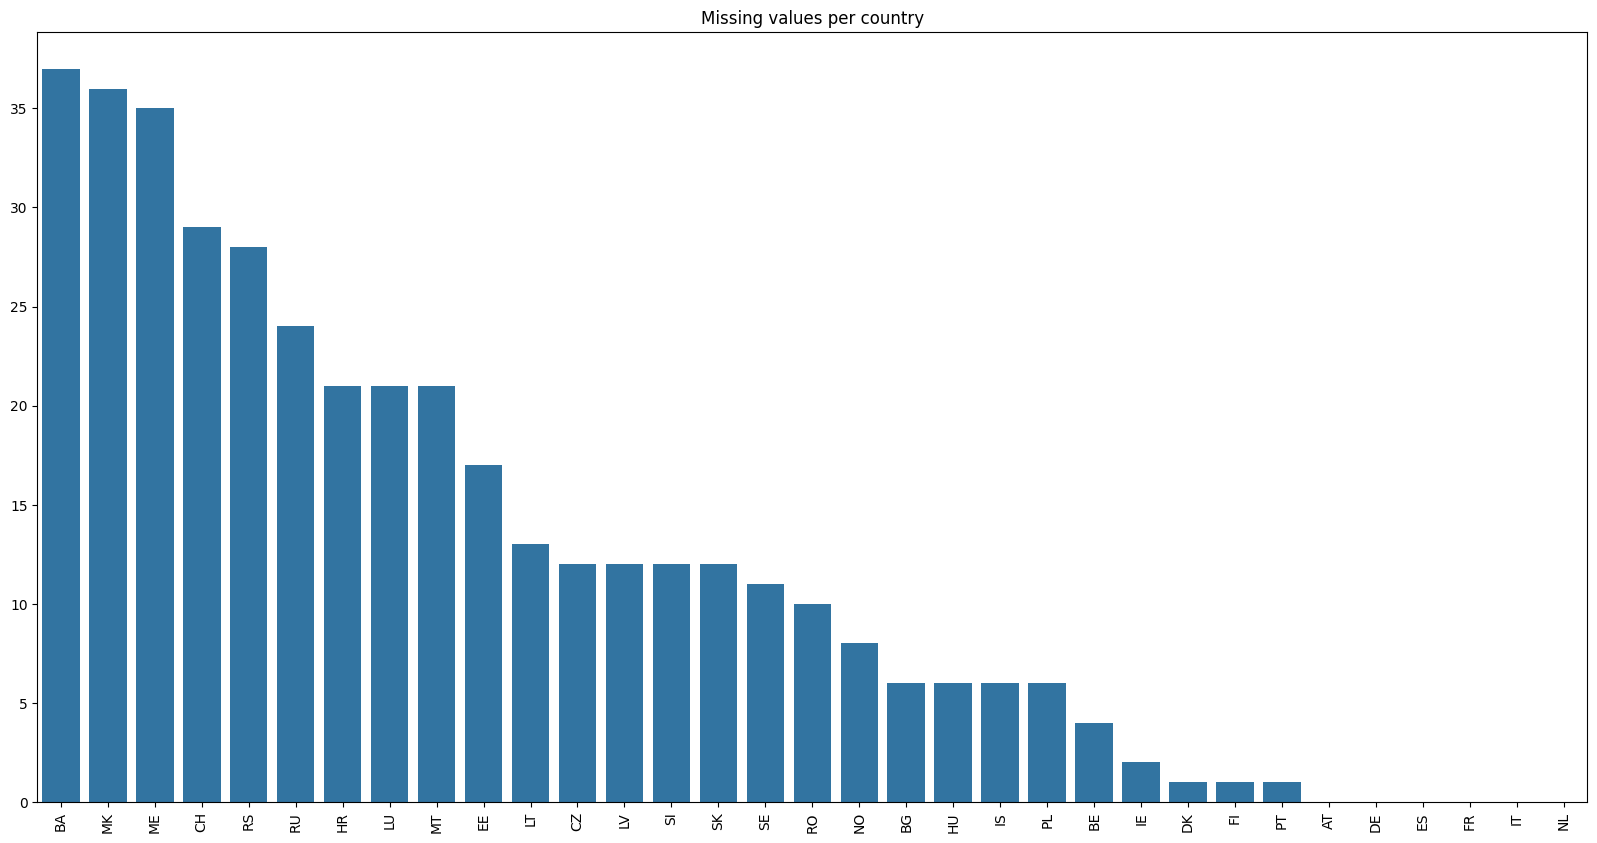

In [27]:
time_span = 43  # max timespan =43 current year - time_span
sector = "TOTAL"  # All sectors
unit = "EUR_HAB"  # Euro per inhabitant
# access the data this can be accessed like [-2*time_span:] but the first 4 columns should also be kepped since they have valueable information
import seaborn as sns
import matplotlib.pyplot as plt
import math

dataBySector = RD_EXP_BY_SECTOR[
    (RD_EXP_BY_SECTOR["sectperf"] == sector) & (RD_EXP_BY_SECTOR["unit"] == unit)
]
missingData = {}
# check for missing values per country


def getMissingDataForTimespan(dataBySector, time_span, plotCountries=[]):
    missingData = {}

    for country in countries:
        country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
        missing_values = country_data.isnull().sum()
        missing_values = missing_values[
            missing_values.index.str.contains(r"\d{4}_value")
        ]
        missingData[country] = sum(missing_values[-time_span:])

    if len(plotCountries) == 0:
        return missingData

    # Plot for the specified countries
    num_cols = 2
    num_rows = math.ceil(len(plotCountries) / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axs = axs.flatten()
    fig.suptitle(f"Missing values for countries: {plotCountries}")
    for idx, country in enumerate(plotCountries):
        ax = axs[idx]
        sns.barplot(x=missing_values.index, y=missing_values.values, ax=ax)
        ax.set_xticklabels(missing_values.index, rotation=90)
        ax.set_title(f"Missing values in {country}")
    # Hide any unused subplots
    for ax in axs[len(plotCountries) :]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

    return missingData


missingData = getMissingDataForTimespan(dataBySector, time_span, ["BA", "DE", "BG"])
# plot the distribution of missing values per country
# sort the values by the number of missing values
missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country")
plt.show()

The top chart shows us for a timespan of 43 years many countries have missing values. Only a few like DE AT FR have values for all years.

Find the timespan where got the most data to support the analysis.


<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/3962658547.py:14: SyntaxWarning: invalid escape sequence '\T'
  time_span * len(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())


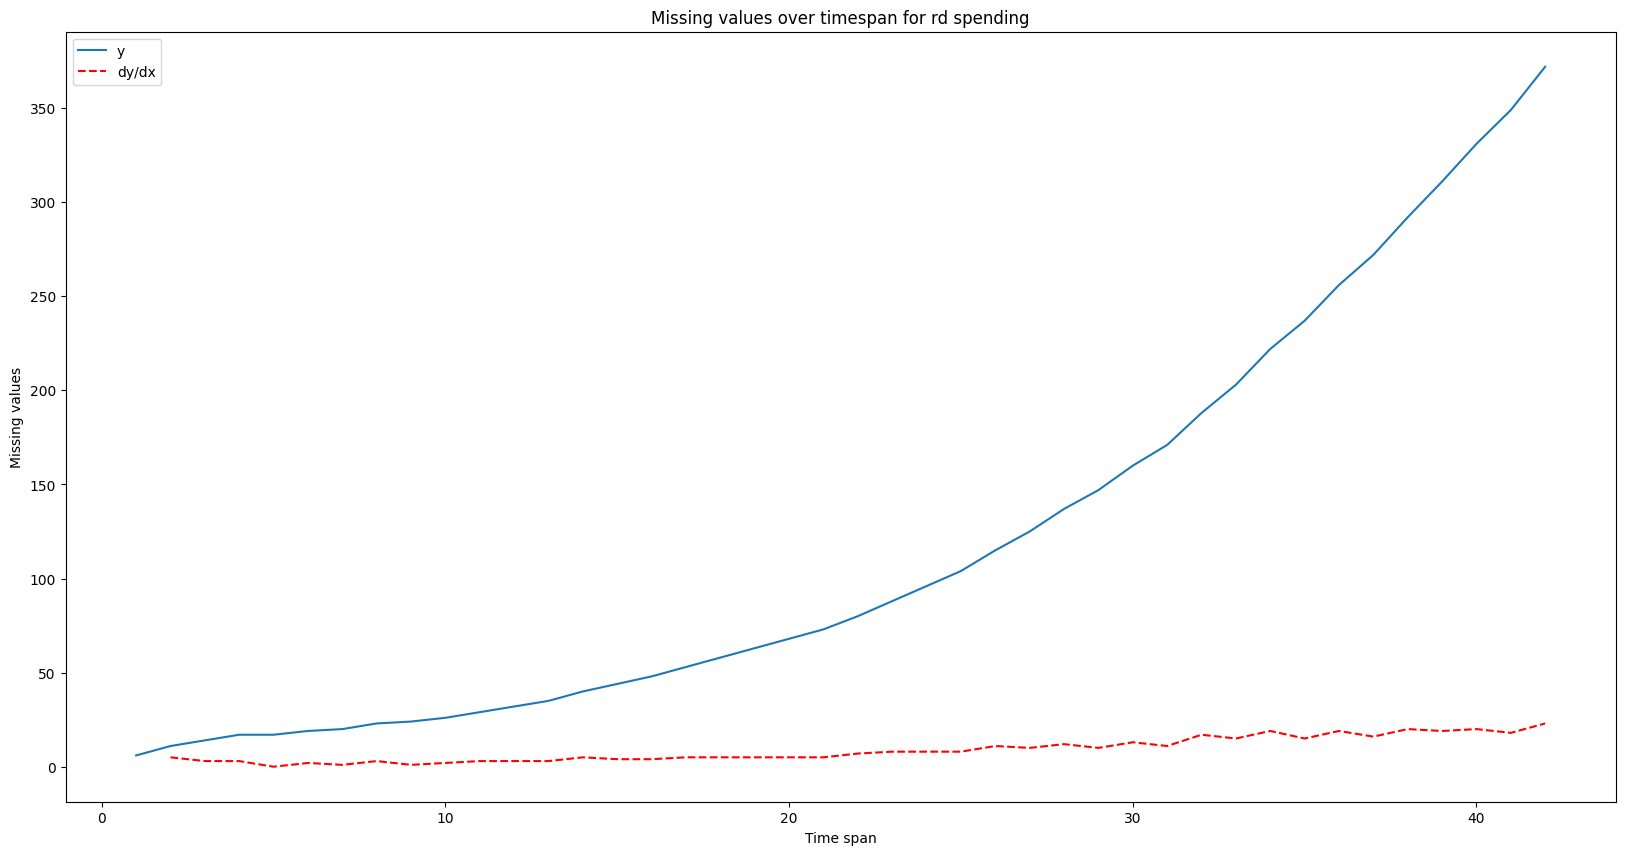

   x   y  y_total  rel_missing_values  dy/dx
0  1   6       33            0.181818    NaN
1  2  11       66            0.166667    5.0
2  3  14       99            0.141414    3.0
3  4  17      132            0.128788    3.0
4  5  17      165            0.103030    0.0


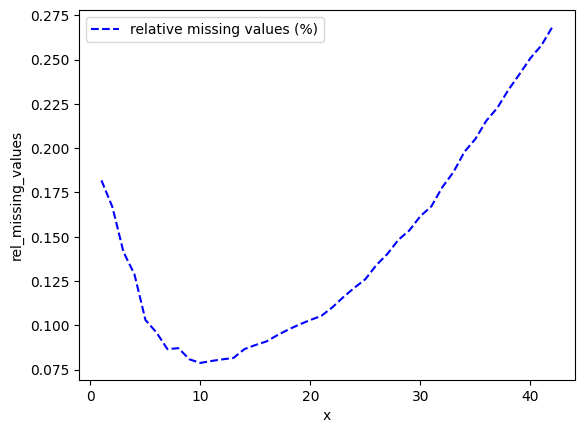

In [28]:
import pandas as pd

plotData = pd.DataFrame()
# add columns x and y


plotData["x"] = range(1, 43)
plotData["y"] = [
    sum(getMissingDataForTimespan(dataBySector, time_span, []).values())
    for time_span in range(1, 43)
]
# plotData["total_y"] = [sum(dataBySector.)]
plotData["y_total"] = [
    time_span * len(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())
    for time_span in range(1, 43)
]
plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]
# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()
# Plotting the data and its derivative
plt.figure(figsize=(20, 10))
# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")
# Plot the derivative
sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)


plt.xlabel("Time span")


plt.ylabel("Missing values")


plt.title("Missing values over timespan for rd spending")
plt.legend()


plt.show()


print(plotData.head())


sns.lineplot(
    data=plotData,
    x="x",
    y="rel_missing_values",
    label="relative missing values (%)",
    linestyle="--",
    color="blue",
)


plt.show()

The chart above shows us that the longer the timespan the less countries have data. A sweet spot seems to be around 20 years.

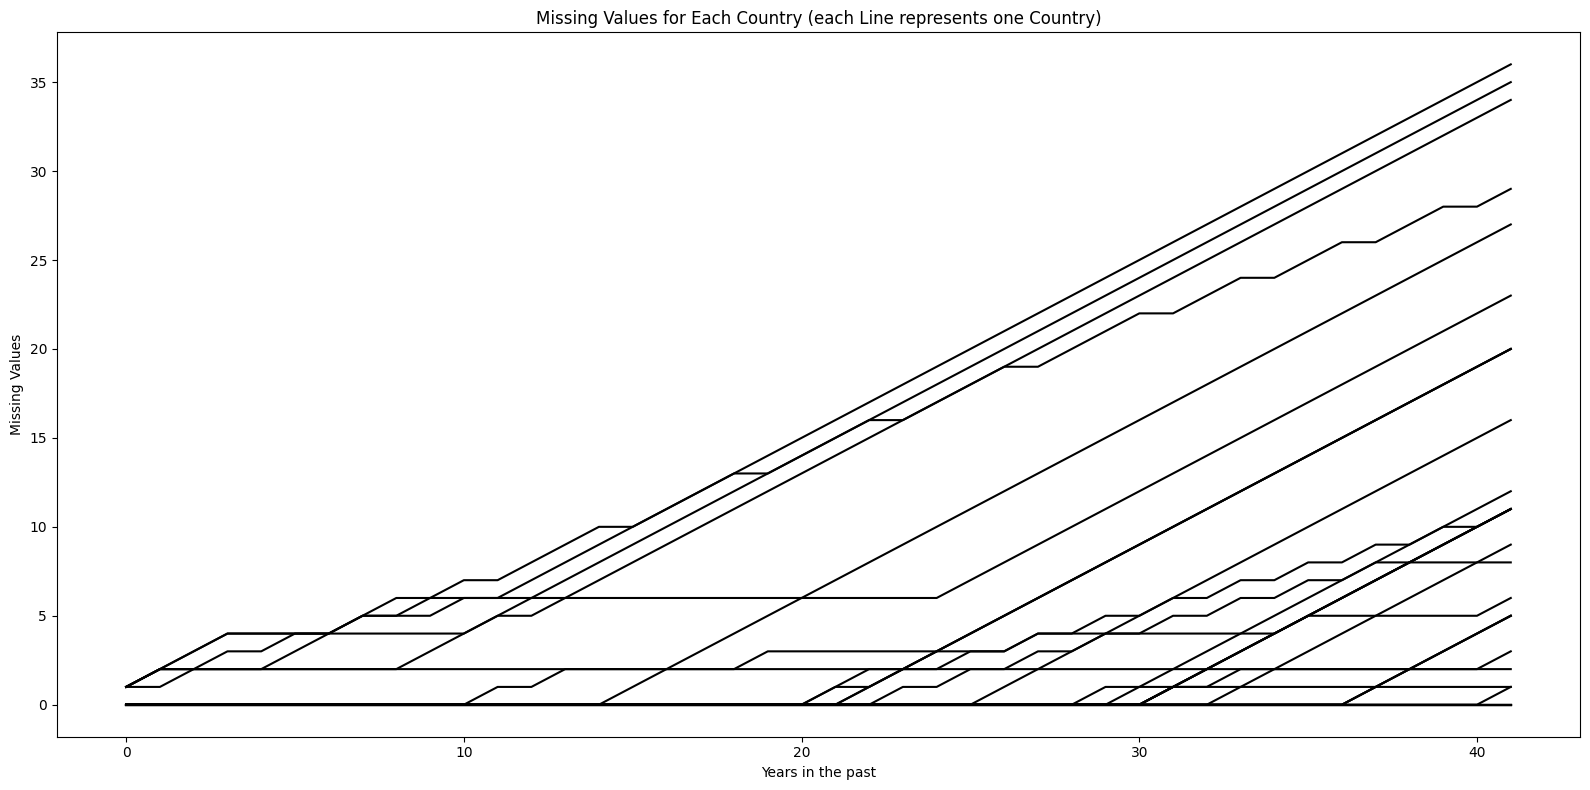

In [29]:
# print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(
    getMissingDataForTimespan(dataBySector, time_span) for time_span in range(1, 43)
)
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
# print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={"index": "Country"}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(
    id_vars="Country", var_name="Column", value_name="Value"
)

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x="Column", y="Value", hue="Country", palette=("black",))

# Customize plot
plt.title("Missing Values for Each Country (each Line represents one Country)")
plt.xlabel("Years in the past")
plt.ylabel("Missing Values")
plt.legend([],[],frameon=False)
plt.tight_layout()
plt.show()

Again the top chart shows that for most countries the missing values are beginning to increase after 20-25 years.

### Decisions so far

Based on the analysis so far, a suitable range for continuing would be a timespan of somewhere between 20 and 25 years. This is the timespan, where the share of missing values is quite small, but the timeframe itself is not to little.


## Analysis Patent Applications

A second feature with high correlation with the final score is the patent activity. In this section we will look at the number of patent applications in the EU countries.

### Download & Preprocess Data

Similar to the Eurostat data, we will download and preprocess the patent application data.

<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/1836731359.py:8: SyntaxWarning: invalid escape sequence '\T'
  filteredPatentApplications = filteredPatentApplications[filteredPatentApplications["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]
/tmp/ipykernel_262139/1836731359.py:23: SyntaxWarning: invalid escape sequence '\T'
  time_span * len(filteredPatentApplications["geo\TIME_PERIOD"].unique())


    freq    unit geo\TIME_PERIOD  1978_value 1978_flag  1979_value 1979_flag  \
285    A  P_MHAB              AT         NaN         :       35.12             
287    A  P_MHAB              BE         NaN         :       25.18             
288    A  P_MHAB              BG         NaN         :         NaN         :   
291    A  P_MHAB              CH         NaN         :      141.22             
293    A  P_MHAB              CZ         NaN         :         NaN         :   
294    A  P_MHAB              DE         NaN         :       81.31             
295    A  P_MHAB              DK         NaN         :       21.54             
298    A  P_MHAB              EE         NaN         :         NaN         :   
300    A  P_MHAB              ES         NaN         :        0.70             
302    A  P_MHAB              FI         NaN         :        7.99             
303    A  P_MHAB              FR         NaN         :       39.06             
304    A  P_MHAB              HR        

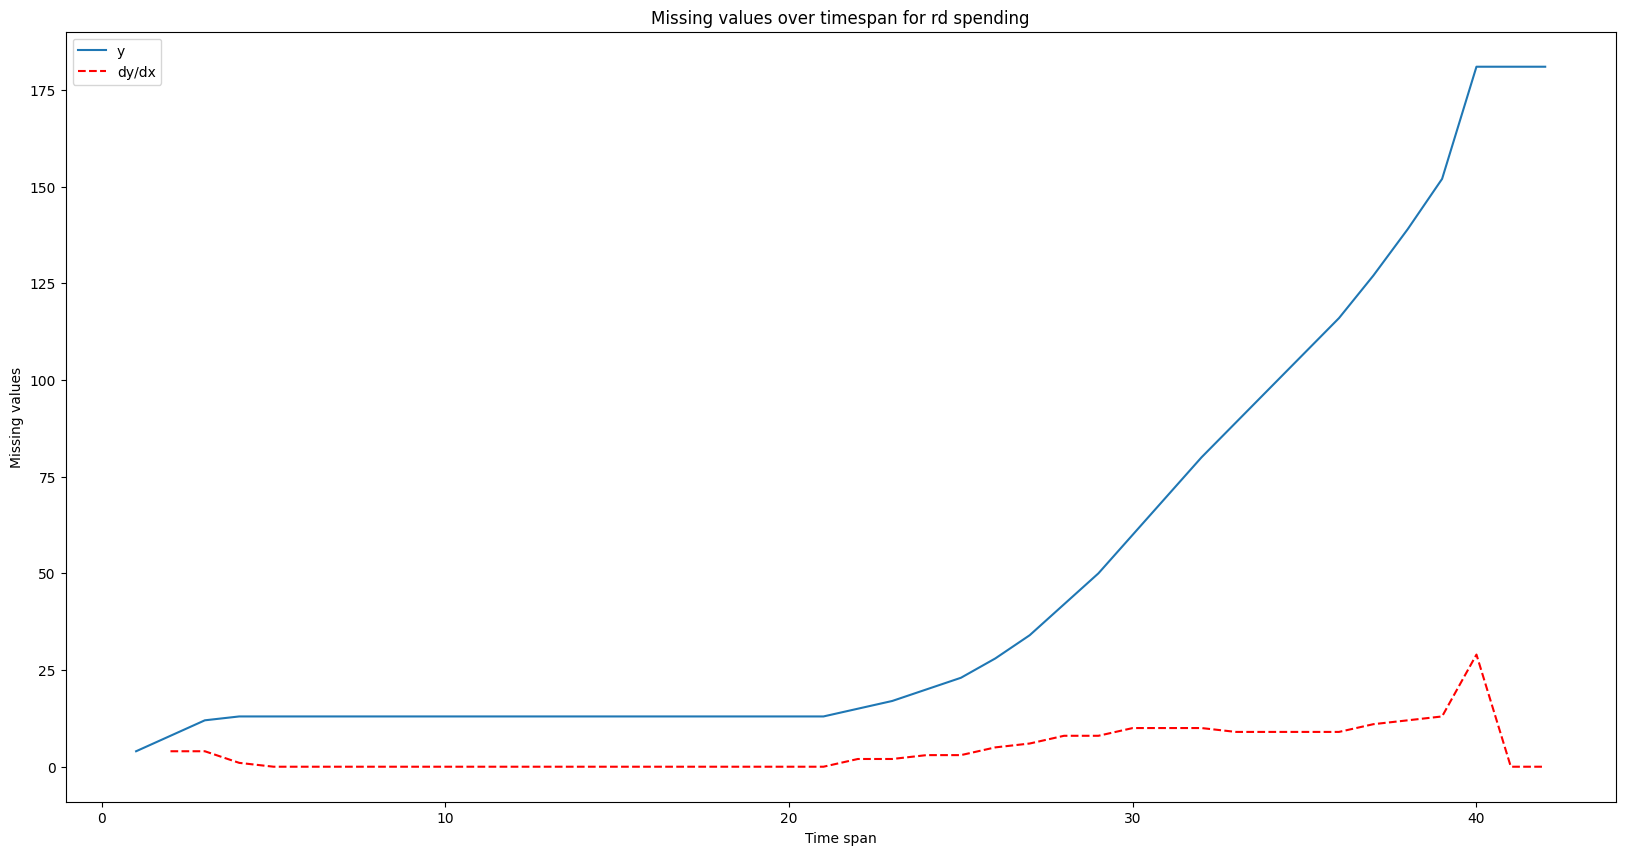

   x   y  y_total  rel_missing_values  dy/dx
0  1   4       30            0.133333    NaN
1  2   8       60            0.133333    4.0
2  3  12       90            0.133333    4.0
3  4  13      120            0.108333    1.0
4  5  13      150            0.086667    0.0


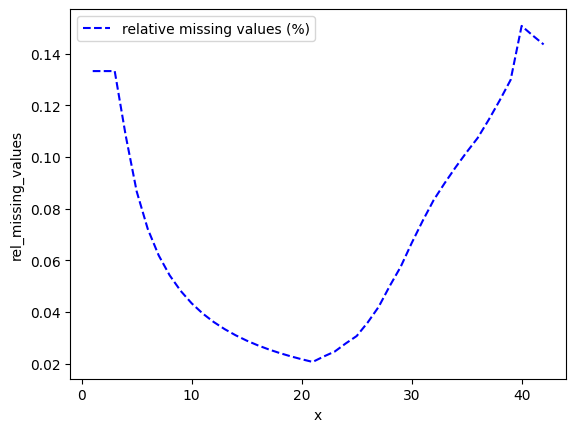

In [30]:
# print(PAT_APPLICATIONS_HIST.head())
unit = "P_MHAB"
sector = "Total"
filteredPatentApplications = PAT_APPLICATIONS_HIST[
    (PAT_APPLICATIONS_HIST["unit"] == unit)
]
#only keep european countries
filteredPatentApplications = filteredPatentApplications[filteredPatentApplications["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]
print(filteredPatentApplications)




plotData = pd.DataFrame()
# add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [
    sum(getMissingDataForTimespan(filteredPatentApplications, time_span).values())
    for time_span in range(1, 43)
]
# plotData["total_y"] = [sum(dataBySector.)]
plotData["y_total"] = [
    time_span * len(filteredPatentApplications["geo\TIME_PERIOD"].unique())
    for time_span in range(1, 43)
]
plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]


# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)


plt.xlabel("Time span")
plt.ylabel("Missing values")
plt.title("Missing values over timespan for rd spending")
plt.legend()
plt.show()

print(plotData.head())
sns.lineplot(
    data=plotData,
    x="x",
    y="rel_missing_values",
    label="relative missing values (%)",
    linestyle="--",
    color="blue",
)
plt.show()

Similar results as R&D expenditures.

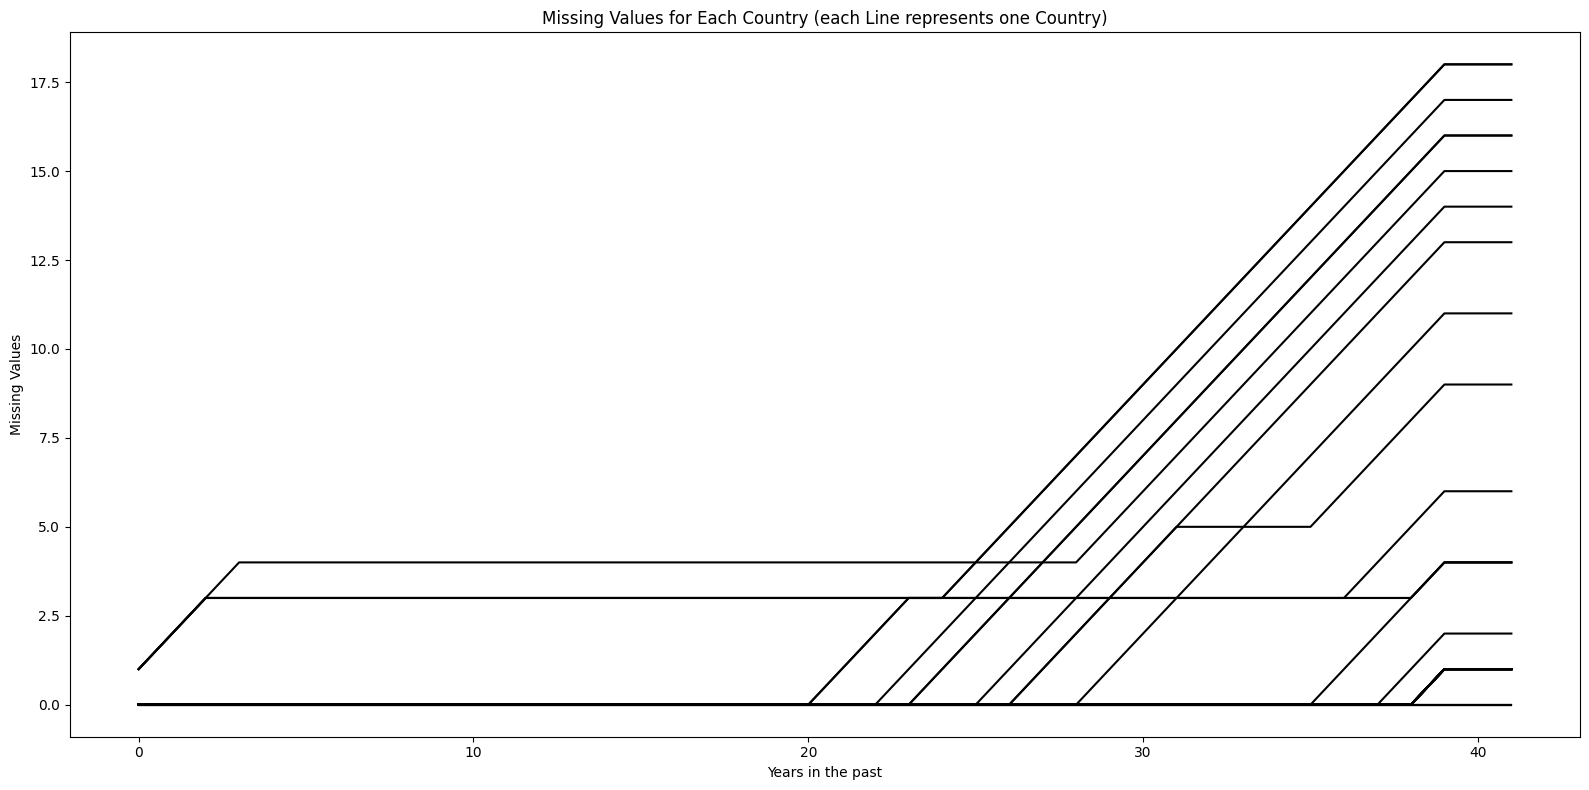

In [31]:
# print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(
    getMissingDataForTimespan(filteredPatentApplications, time_span, [])
    for time_span in range(1, 43)
)
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
# print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={"index": "Country"}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(
    id_vars="Country", var_name="Column", value_name="Value"
)

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x="Column", y="Value", hue="Country", palette=("black",))

# Customize plot
plt.title("Missing Values for Each Country (each Line represents one Country)")
plt.xlabel("Years in the past")
plt.ylabel("Missing Values")
plt.legend([],[],frameon=False)
plt.tight_layout()
plt.show()

### Decisions on Patent Applications

Also here the most optimal range of values seems to again be somewhat between 20 and 25 years in the past.


# Euurostat Data Preprocessing

Now, after we did some upfront analysis, we will continue with preparing a suitable dataset for further analysis.

## R&D spending

Let's start with the R&D spending.


In [32]:
sector = "TOTAL"
unit1 = "EUR_HAB"
unit2 = "PC_GDP"
year = 2024 - 25

# Filter Sector and units
RD_filtered = RD_EXP_BY_SECTOR[
    (RD_EXP_BY_SECTOR["sectperf"] == sector)
    & ((RD_EXP_BY_SECTOR["unit"] == unit1) | (RD_EXP_BY_SECTOR["unit"] == unit2))
]

# Drop unnecessary columns and rename columns
RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)

# Change to long format for further preprocessing
RD_long = RD_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
RD_long[["Year", "Indicator"]] = RD_long["Year_Indicator"].str.split("_", expand=True)
RD_long.drop(columns=["Year_Indicator"], inplace=True)
RD_long["Year"] = pd.to_numeric(RD_long["Year"])

# Filter to relevant time range
RD_long = RD_long[RD_long["Year"] >= year]


# Rename the different units
RD_long["Unit"].replace(
    {"EUR_HAB": "RD_spend_Euro_per_Inhabitant", "PC_GDP": "RD_spend_Percent_of_GDP"},
    inplace=True,
)

# RD_long.reset_index(drop=True, inplace=True)


# Separate value and flag in two columns
RD_long = RD_long.pivot_table(
    index=["Country", "Year", "Unit"],
    values="Value",
    columns="Indicator",
    aggfunc="first",
)

# Rename to capital letters
RD_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

# Convert value to numeric value for imputation
RD_long["Value"] = pd.to_numeric(RD_long["Value"])

# Reset index created by pivot
RD_long.reset_index(inplace=True)

# Remove Indicator title for columns
RD_long.columns.name = None

# RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)
display(RD_long)

<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/956209663.py:14: SyntaxWarning: invalid escape sequence '\T'
  RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/tmp/ipykernel_262139/956209663.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
/tmp/ipykernel_262139/956209663.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/tmp/ipykernel_262139/95620966

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
1645,SK,2021,RD_spend_Percent_of_GDP,,0.900
1646,SK,2022,RD_spend_Euro_per_Inhabitant,,197.802
1647,SK,2022,RD_spend_Percent_of_GDP,,0.980
1648,SK,2023,RD_spend_Euro_per_Inhabitant,,235.765


In [33]:
def plotFlatStruc(df, x, y, hue, title):
    plt.plot(df[x], df[y], marker="o", linestyle="-", color="b")
    plt.title(title)
    plt.xticks(df[x], rotation=45)
    plt.show()

## Imputation of missing values using interpolation
Even though we selected a time frame with as little missing values as possible, we still do have some. These we now try to impute per country.

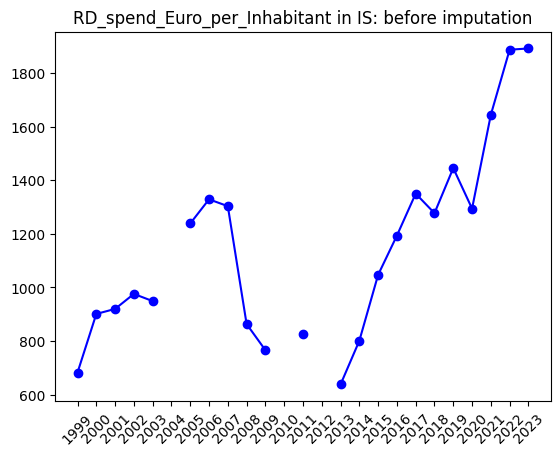

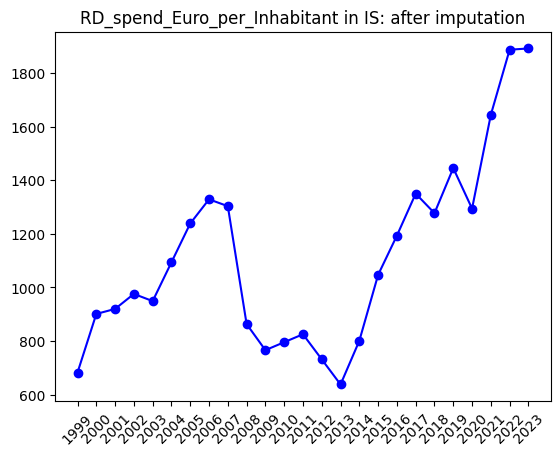

In [34]:
# Impute NaNs

country_to_test = "IS"
unit_to_test = "RD_spend_Euro_per_Inhabitant"   
#display(RD_long)

#display(
#    RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)]
#)

plotFlatStruc(
    RD_long[
        (RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
    title=unit_to_test + " in " + country_to_test + ": before imputation"

)

RD_long["Value"] = RD_long.groupby(by=["Country", "Unit"])["Value"].transform(
    lambda group: group.interpolate(method="index")
)

#display(
#    RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)]
#)

plotFlatStruc(
    RD_long[
        (RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
    title=unit_to_test + " in " + country_to_test + ": after imputation"
)

In [35]:
display(RD_long)

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
1645,SK,2021,RD_spend_Percent_of_GDP,,0.900
1646,SK,2022,RD_spend_Euro_per_Inhabitant,,197.802
1647,SK,2022,RD_spend_Percent_of_GDP,,0.980
1648,SK,2023,RD_spend_Euro_per_Inhabitant,,235.765


## Preprocessing Patent Applications
Next, we are preprocessing the patent applications. Due to changes in the dataset, we are doing that in a two step approach (1999-2003 and 2004-2023), to combine the values of best availability in each dataset.

## Historical Data (1999-2003)


In [36]:
unit1 = "P_MHAB"
# unit2 = "PC_GDP"
year = 2024 - 25

# Filter Sector and units
PAT_hist_filtered = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit1)]

# Drop unnecessary columns and rename columns
PAT_hist_filtered.drop(columns=["freq"], inplace=True)

PAT_hist_filtered = PAT_hist_filtered[PAT_hist_filtered["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]

PAT_hist_filtered.rename(
    columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
)

# #Change to long format for further preprocessing
PAT_hist_long = PAT_hist_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
PAT_hist_long[["Year", "Indicator"]] = PAT_hist_long["Year_Indicator"].str.split(
    "_", expand=True
)

PAT_hist_long.drop(columns=["Year_Indicator"], inplace=True)
PAT_hist_long["Year"] = pd.to_numeric(PAT_hist_long["Year"])

# Filter to relevant time range
PAT_hist_long = PAT_hist_long[
    (PAT_hist_long["Year"] >= year) & (PAT_hist_long["Year"] <= 2003)
]

# Rename the different units
PAT_hist_long["Unit"].replace(
    {"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True
)


display(PAT_hist_long)

<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/2899670760.py:11: SyntaxWarning: invalid escape sequence '\T'
  PAT_hist_filtered = PAT_hist_filtered[PAT_hist_filtered["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]
/tmp/ipykernel_262139/2899670760.py:14: SyntaxWarning: invalid escape sequence '\T'
  columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
/tmp/ipykernel_262139/2899670760.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_hist_filtered.drop(columns=["freq"], inplace=True)
/tmp/ipykernel_262139/2899670760.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series thr

,Country,Unit,Value,Year,Indicator
1260,AT,Pat_appl_per_million_inhabitants,134.33,1999,value
1261,BE,Pat_appl_per_million_inhabitants,131.63,1999,value
1262,BG,Pat_appl_per_million_inhabitants,0.97,1999,value
1263,CH,Pat_appl_per_million_inhabitants,350.55,1999,value
1264,CZ,Pat_appl_per_million_inhabitants,5.8,1999,value
...,...,...,...,...,...
1555,RO,Pat_appl_per_million_inhabitants,,2003,flag
1556,RU,Pat_appl_per_million_inhabitants,,2003,flag
1557,SE,Pat_appl_per_million_inhabitants,,2003,flag
1558,SI,Pat_appl_per_million_inhabitants,,2003,flag


## New Data (2004 - 2023)


In [37]:
unit1 = "P_MHAB"
coop = "APPL"

# Filter Sector and units
PAT_new_filtered = PAT_APPLICATIONS_NEW[
    (PAT_APPLICATIONS_NEW["unit"] == unit1) & (PAT_APPLICATIONS_NEW["coop_ptn"] == coop)
]

#filter only european countries
Pat_new_filtered = PAT_new_filtered[PAT_new_filtered["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]

# Drop unnecessary columns and rename columns
PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)

PAT_new_filtered.rename(
    columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
)

# #Change to long format for further preprocessing
PAT_new_long = PAT_new_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
PAT_new_long[["Year", "Indicator"]] = PAT_new_long["Year_Indicator"].str.split(
    "_", expand=True
)

PAT_new_long.drop(columns=["Year_Indicator"], inplace=True)


PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])

# Filter to relevant time range
PAT_new_long = PAT_new_long[(PAT_new_long["Year"] >= 2004)]

# Rename the different units
PAT_new_long["Unit"].replace(
    {"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True
)

display(PAT_new_long)

<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_262139/3357270391.py:10: SyntaxWarning: invalid escape sequence '\T'
  Pat_new_filtered = PAT_new_filtered[PAT_new_filtered["geo\TIME_PERIOD"].apply(filterEuropeanCountries)]
/tmp/ipykernel_262139/3357270391.py:16: SyntaxWarning: invalid escape sequence '\T'
  columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
/tmp/ipykernel_262139/3357270391.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)
/tmp/ipykernel_262139/3357270391.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Country,Unit,Value,Year,Indicator
0,AL,Pat_appl_per_million_inhabitants,NaN,2004,value
1,AT,Pat_appl_per_million_inhabitants,122.37,2004,value
2,BA,Pat_appl_per_million_inhabitants,NaN,2004,value
3,BE,Pat_appl_per_million_inhabitants,143.27,2004,value
4,BG,Pat_appl_per_million_inhabitants,2.07,2004,value
...,...,...,...,...,...
1515,RS,Pat_appl_per_million_inhabitants,bp,2023,flag
1516,SE,Pat_appl_per_million_inhabitants,p,2023,flag
1517,SI,Pat_appl_per_million_inhabitants,p,2023,flag
1518,SK,Pat_appl_per_million_inhabitants,p,2023,flag


## Combinining Historical and Current
Now, we want to combine the two preprocessed datasets for patent applications.

In [38]:
PAT_comb_long = pd.concat([PAT_hist_long, PAT_new_long], axis=0)
PAT_comb_long.reset_index(drop=True, inplace=True)


# Separate value and flag in two columns
PAT_comb_long = PAT_comb_long.pivot_table(
    index=["Country", "Year", "Unit"],
    values="Value",
    columns="Indicator",
    aggfunc="first",
)


# Rename to capital letters
PAT_comb_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

# Convert value to numeric value for imputation
PAT_comb_long["Value"] = pd.to_numeric(PAT_comb_long["Value"])

# Reset index created by pivot
PAT_comb_long.reset_index(inplace=True)

# Remove Indicator title for columns
PAT_comb_long.columns.name = None

PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])


# RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)

display(PAT_comb_long)

,Country,Year,Unit,Flag,Value
0,AL,2004,Pat_appl_per_million_inhabitants,:,NaN
1,AL,2005,Pat_appl_per_million_inhabitants,:,NaN
2,AL,2006,Pat_appl_per_million_inhabitants,:,NaN
3,AL,2007,Pat_appl_per_million_inhabitants,:,NaN
4,AL,2008,Pat_appl_per_million_inhabitants,:,NaN
...,...,...,...,...,...
905,TR,2019,Pat_appl_per_million_inhabitants,be,5.70
906,TR,2020,Pat_appl_per_million_inhabitants,,7.26
907,TR,2021,Pat_appl_per_million_inhabitants,,8.73
908,TR,2022,Pat_appl_per_million_inhabitants,,6.59


## Imputation of missing Values
We can impute missing values, as we've already done it with R&D spending


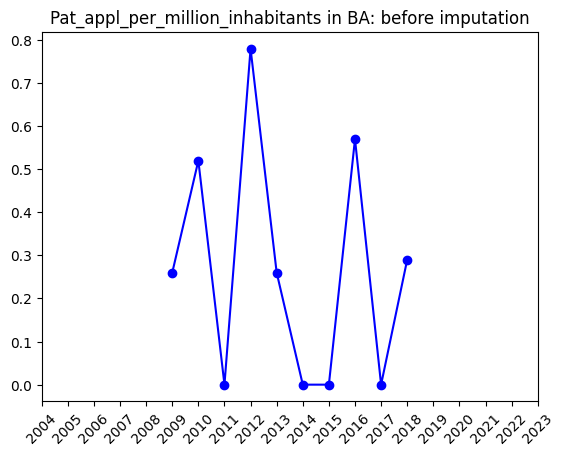

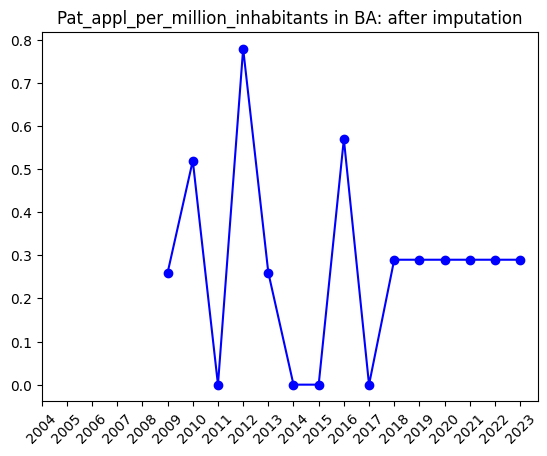

In [39]:
# Impute NaNs

country_to_test = "BA"
unit_to_test = "Pat_appl_per_million_inhabitants"

#display(
#    PAT_comb_long[
#        (PAT_comb_long["Unit"] == unit_to_test)
#        & (PAT_comb_long["Country"] == country_to_test)
#    ]
#)

plotFlatStruc(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
    title=unit_to_test + " in " + country_to_test + ": before imputation"

)

PAT_comb_long["Value"] = PAT_comb_long.groupby(by=["Country", "Unit"])[
    "Value"
].transform(lambda group: group.interpolate(method="index"))

#display(
#    PAT_comb_long[
#        (PAT_comb_long["Unit"] == unit_to_test)
#        & (PAT_comb_long["Country"] == country_to_test)
#    ]
#)

plotFlatStruc(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
    title=unit_to_test + " in " + country_to_test + ": after imputation"

)

## Merge RD and Patent Data

Now we combine the RD expenditure and patent application dataset into on merged df.

In [40]:
merged_df = pd.concat([RD_long, PAT_comb_long], axis=0)
merged_df.reset_index(drop=True, inplace=True)
merged_df.sort_values(by=["Country", "Year", "Unit"], inplace=True)

merged_df.set_index(["Country", "Year", "Unit"], inplace=True)
merged_df.sort_values(by=["Country", "Year"], inplace=True)
display(merged_df)

Flag  Value
Country Year Unit                                        
AL      2004 Pat_appl_per_million_inhabitants    :    NaN
        2005 Pat_appl_per_million_inhabitants    :    NaN
        2006 Pat_appl_per_million_inhabitants    :    NaN
        2007 Pat_appl_per_million_inhabitants    :    NaN
        2008 Pat_appl_per_million_inhabitants    :    NaN
...                                            ...    ...
TR      2019 Pat_appl_per_million_inhabitants   be   5.70
        2020 Pat_appl_per_million_inhabitants        7.26
        2021 Pat_appl_per_million_inhabitants        8.73
        2022 Pat_appl_per_million_inhabitants        6.59
        2023 Pat_appl_per_million_inhabitants    p   7.05

[2560 rows x 2 columns]

Looks like for a time span sub 20-30 years, the data has not too many missing values. Also the number of missing values starts to increase after a time span of ca 23 years.


Do the same for the patent dataset, and see if the same pattern is observed.


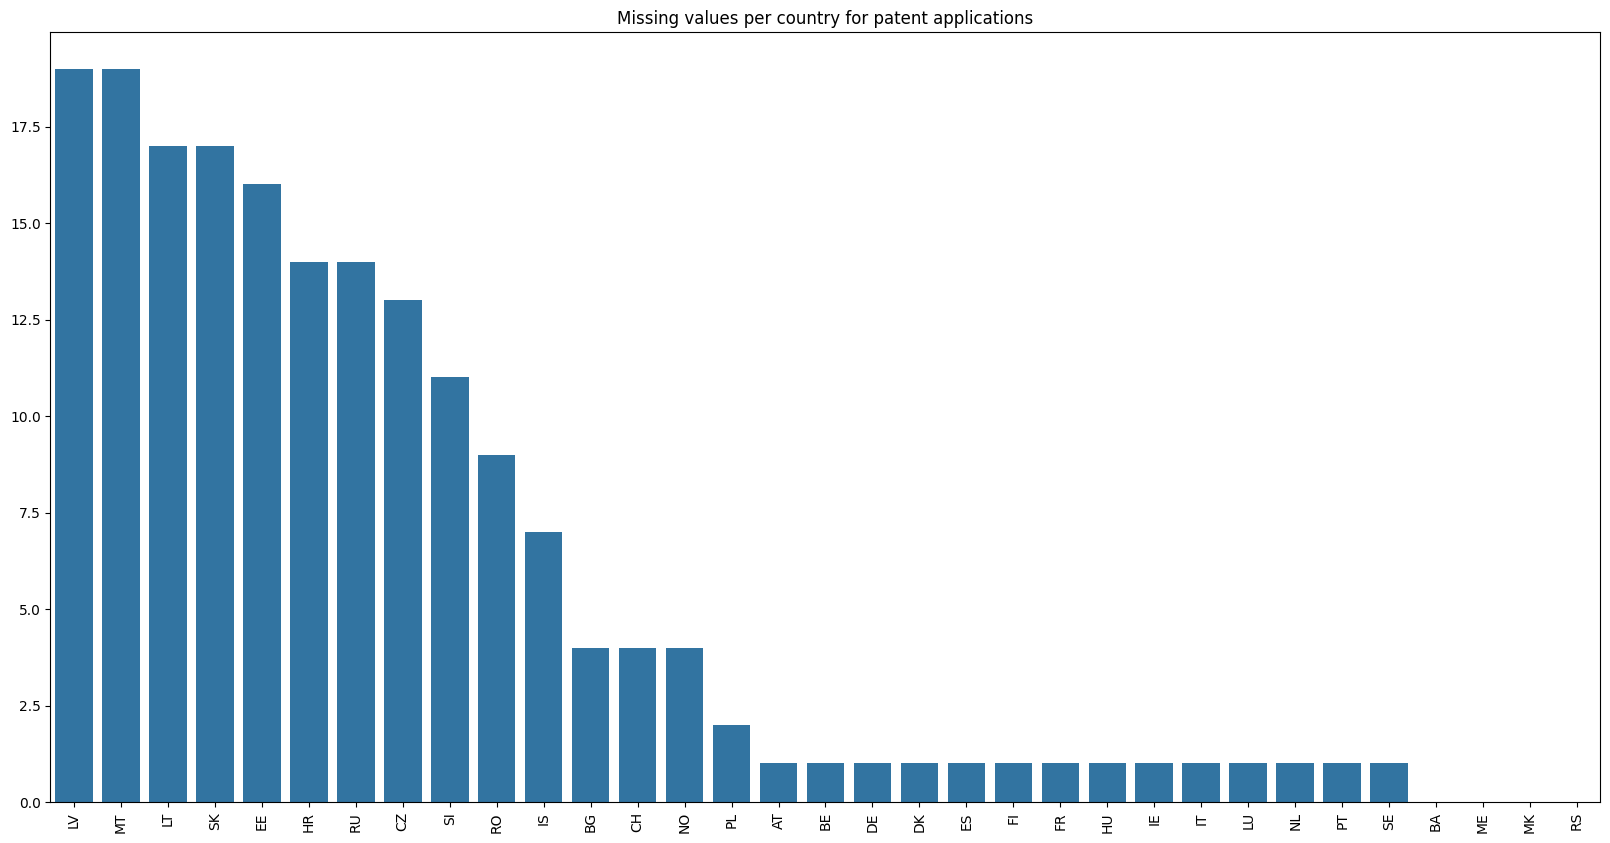

In [41]:
#Todo: warum machen wir das jetzt nochmal? das ist ja oben schon gemacht oder?


time_span = 43
unit = "NR"  # should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

missingData = getMissingDataForTimespan(data, time_span, [])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()

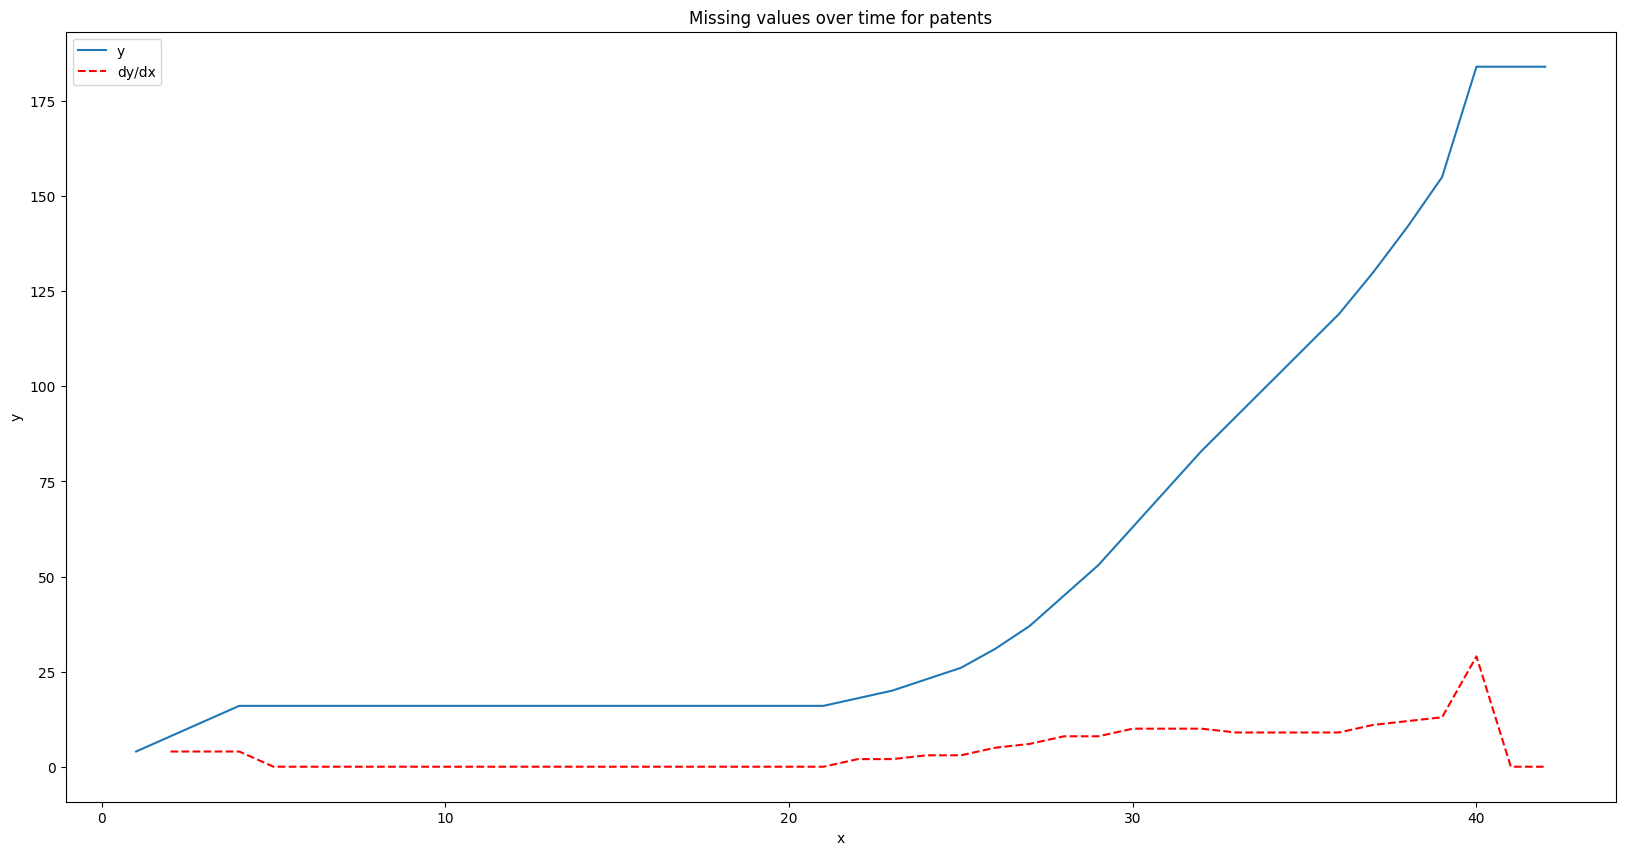

In [42]:
import pandas as pd


#TODO: warum wieder soviele spaces hier?
plotData = pd.DataFrame()


# add columns x and y


plotData["x"] = range(1, 43)


plotData["y"] = [
    sum(getMissingDataForTimespan(data, time_span, []).values())
    for time_span in range(1, 43)
]



# Calculate the derivative (numerical approximation)


plotData["dy/dx"] = plotData["y"].diff()



# Plotting the data and its derivative


plt.figure(figsize=(20, 10))



# Plot the original data


sns.lineplot(data=plotData, x="x", y="y", label="y")



# Plot the derivative


sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)


plt.title("Missing values over time for patents")
plt.legend()


plt.show()

Looks like the patent dataset as good data for the last 20-25 years.


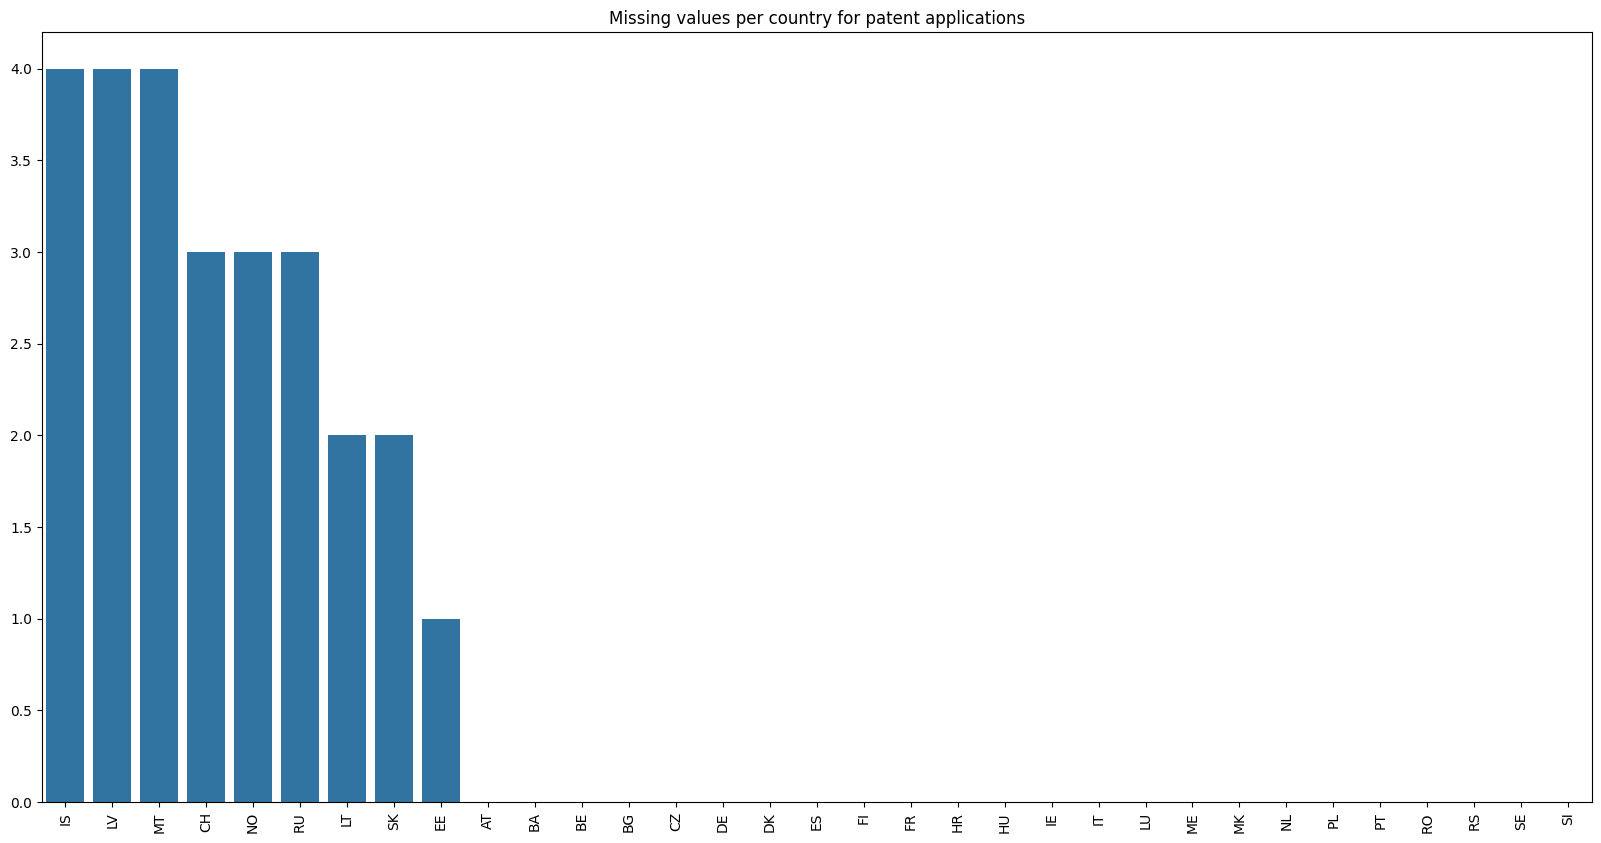

In [43]:
time_span = 25
unit = "NR"  # should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]
#TODO: checke nicht warum wir das jetzt nochmal machen?

missingData = getMissingDataForTimespan(data, time_span, [])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()

## Merge Eurostat and GII Data

In this step we merge the preprocess Eurostat data with the GII data. The goal is to once again check and confirm the correlation with the GII final score from our independently preprocessed and prepared features.

In [44]:
country_abbreviations = {
    'Albania': 'AL', 'Austria': 'AT', 'Belarus': 'BY', 'Belgium': 'BE', 
    'Bosnia and Herzegovina': 'BA', 'Bulgaria': 'BG', 'Croatia': 'HR', 
    'Czech Republic': 'CZ', 'Denmark': 'DK', 'Estonia': 'EE', 
    'Finland': 'FI', 'France': 'FR', 'Germany': 'DE', 'Greece': 'EL', 
    'Hungary': 'HU', 'Iceland': 'IS', 'Ireland': 'IE', 'Italy': 'IT', 
    'Latvia': 'LV', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Malta': 'MT', 
    'Montenegro': 'ME', 'Netherlands': 'NL', 'North Macedonia': 'MK', 
    'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 
    'Republic of Moldova': 'MD', 'Romania': 'RO', 'Russian Federation': 'RU', 
    'Serbia': 'RS', 'Slovakia': 'SK', 'Slovenia': 'SI', 'Spain': 'ES', 
    'Sweden': 'SE', 'Switzerland': 'CH', 'Ukraine': 'UA', 
    'United Kingdom': 'UK'
}

GII_2023_prepared['Country'] = GII_2023_prepared.index.map(country_abbreviations)

/tmp/ipykernel_262139/1684768124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GII_2023_prepared['Country'] = GII_2023_prepared.index.map(country_abbreviations)


In [45]:
merged_df.reset_index(inplace=True)
display(merged_df)
merged_df_pivoted = merged_df.pivot(index=['Country', 'Year'], columns="Unit", values="Value")
display(merged_df_pivoted)

,Country,Year,Unit,Flag,Value
0,AL,2004,Pat_appl_per_million_inhabitants,:,NaN
1,AL,2005,Pat_appl_per_million_inhabitants,:,NaN
2,AL,2006,Pat_appl_per_million_inhabitants,:,NaN
3,AL,2007,Pat_appl_per_million_inhabitants,:,NaN
4,AL,2008,Pat_appl_per_million_inhabitants,:,NaN
...,...,...,...,...,...
2555,TR,2019,Pat_appl_per_million_inhabitants,be,5.70
2556,TR,2020,Pat_appl_per_million_inhabitants,,7.26
2557,TR,2021,Pat_appl_per_million_inhabitants,,8.73
2558,TR,2022,Pat_appl_per_million_inhabitants,,6.59


Unit          Pat_appl_per_million_inhabitants  RD_spend_Euro_per_Inhabitant  \
Country Year                                                                   
AL      2004                               NaN                           NaN   
        2005                               NaN                           NaN   
        2006                               NaN                           NaN   
        2007                               NaN                           NaN   
        2008                               NaN                           NaN   
...                                        ...                           ...   
TR      2019                              5.70                           NaN   
        2020                              7.26                           NaN   
        2021                              8.73                           NaN   
        2022                              6.59                           NaN   
        2023                              7.05                           NaN   

Unit          RD_spend_Percent_of_GDP  
Country Year                           
AL      2004                      NaN  
        2005                      NaN  
        2006                      NaN  
        2007                      NaN  
        2008                      NaN  
...                               ...  
TR      2019                      NaN  
        2020                      NaN  
        2021                      NaN  
        2022                      NaN  
        2023                      NaN  

[950 rows x 3 columns]

Now, we merge the GII data from 2023 with the Eurostat data from 2023.

In [46]:
merged_df_pivoted.reset_index(inplace=True)
merged_df_filtered = merged_df_pivoted[(merged_df_pivoted["Year"] == 2023)]
merged_Eurostat_GII = pd.merge(merged_df_filtered, GII_2023_prepared, on=["Country", "Country"], how='inner')


## Correlation between Eurostat Features and GII score
And now, as announced in the beginning, we once again compute the correlation coefficients from the Eurostat features with our final score.

In [47]:

merged_Eurostat_GII = merged_Eurostat_GII[['Country', 'Year', 'Pat_appl_per_million_inhabitants',	'RD_spend_Euro_per_Inhabitant', 'RD_spend_Percent_of_GDP', 'Final']]
merged_Eurostat_GII.set_index(['Country', 'Year'], inplace=True)

#display(result)
print(merged_Eurostat_GII.corrwith(merged_Eurostat_GII['Final']))



Pat_appl_per_million_inhabitants    0.773971
RD_spend_Euro_per_Inhabitant        0.861202
RD_spend_Percent_of_GDP             0.823347
Final                               1.000000
dtype: float64


We can see, that we achieve high correlation with R&D spending in Euro per Inhabitant, but also the correlations with the other two features from Eurostat is quite good. However, we focus on R&D spendings in Euro per Inhabitant in the further analysis.

In [48]:
display(merged_df)
RD_spending = merged_df[merged_df['Unit'] == "RD_spend_Euro_per_Inhabitant"]
#RD_spending = merged_df.drop(columns=['level_0', 'index', 'Pat_appl_per_million_inhabitants', 'RD_spend_Percent_of_GDP'])
display(RD_spending)

,Country,Year,Unit,Flag,Value
0,AL,2004,Pat_appl_per_million_inhabitants,:,NaN
1,AL,2005,Pat_appl_per_million_inhabitants,:,NaN
2,AL,2006,Pat_appl_per_million_inhabitants,:,NaN
3,AL,2007,Pat_appl_per_million_inhabitants,:,NaN
4,AL,2008,Pat_appl_per_million_inhabitants,:,NaN
...,...,...,...,...,...
2555,TR,2019,Pat_appl_per_million_inhabitants,be,5.70
2556,TR,2020,Pat_appl_per_million_inhabitants,,7.26
2557,TR,2021,Pat_appl_per_million_inhabitants,,8.73
2558,TR,2022,Pat_appl_per_million_inhabitants,,6.59


,Country,Year,Unit,Flag,Value
21,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
24,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
27,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
30,AT,2002,RD_spend_Euro_per_Inhabitant,,580.918
33,AT,2003,RD_spend_Euro_per_Inhabitant,e,622.446
...,...,...,...,...,...
2526,SK,2019,RD_spend_Euro_per_Inhabitant,,142.482
2529,SK,2020,RD_spend_Euro_per_Inhabitant,,153.710
2532,SK,2021,RD_spend_Euro_per_Inhabitant,,168.202
2535,SK,2022,RD_spend_Euro_per_Inhabitant,,197.802


# Predicting future R&D expenditure

Since we identified the R&D spendings as a good representative for the innovation level of a country, we would now like to use this to predict the future R&D spendings to show a trend in the innovation level for each country.


In [49]:
from statsmodels.tsa.arima.model import ARIMA

#display(RD_spending)

RD_spending_cutoff = RD_spending[RD_spending['Year'] <= 2020]
#display(RD_spending_cutoff)

forecasts = []

for country, group in RD_spending_cutoff.groupby('Country'):
    begyear = max(group['Year'])
    model = ARIMA(group['Value'], order=(2,1,3))
    try:
        model_fit = model.fit()
    except Exception as e:
        print(f"Error: {e}")
        print(f"Failed to fit model for {country}")
        continue
    
    pred = model_fit.forecast(steps=7)
    forecasts.append({'Country': country, 'Year': begyear+1, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[0]})
    forecasts.append({'Country': country, 'Year': begyear+2, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[1]})
    forecasts.append({'Country': country, 'Year': begyear+3, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[2]})
    forecasts.append({'Country': country, 'Year': begyear+4, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[3]})
    forecasts.append({'Country': country, 'Year': begyear+5, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[4]})
    forecasts.append({'Country': country, 'Year': begyear+6, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[5]})
    forecasts.append({'Country': country, 'Year': begyear+7, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[6]})



RD_spending_temp = RD_spending
RD_spending_temp["Flag"] = "data"
RD_spending_forecast = pd.concat([RD_spending_temp, pd.DataFrame(forecasts)], ignore_index=True)
RD_spending_forecast.sort_values(by= ["Country", "Year"], inplace=True)
display(RD_spending_forecast)

/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/t

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,data,471.258000
1,AT,2000,RD_spend_Euro_per_Inhabitant,data,503.446000
2,AT,2001,RD_spend_Euro_per_Inhabitant,data,547.702000
3,AT,2002,RD_spend_Euro_per_Inhabitant,data,580.918000
4,AT,2003,RD_spend_Euro_per_Inhabitant,data,622.446000
...,...,...,...,...,...
1051,SK,2023,RD_spend_Euro_per_Inhabitant,predicted,151.282062
1052,SK,2024,RD_spend_Euro_per_Inhabitant,predicted,157.031786
1053,SK,2025,RD_spend_Euro_per_Inhabitant,predicted,154.747216
1054,SK,2026,RD_spend_Euro_per_Inhabitant,predicted,158.228469


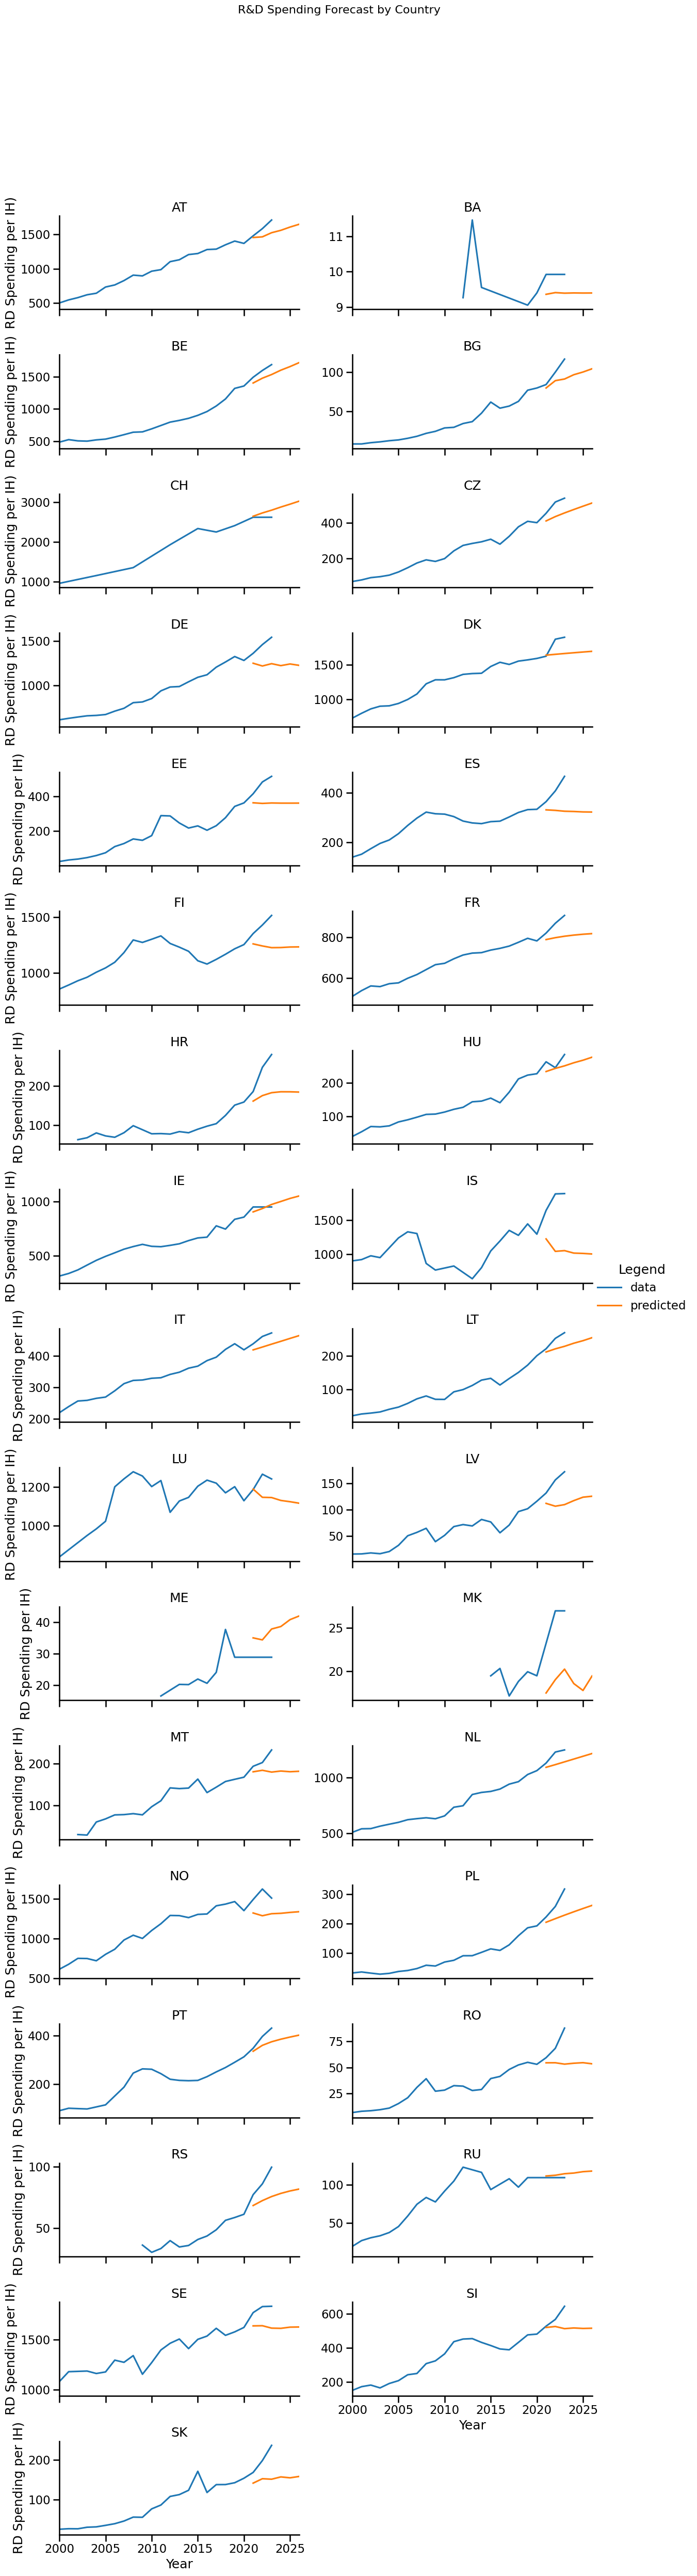

In [ ]:
# g = sns.FacetGrid(RD_spending_forecast, col="Country", hue="Flag", col_wrap=1, height=2, xlim=(2000, 2026))
# g.map(sns.lineplot, "Year", "Value")
# g.add_legend()


import seaborn as sns
import matplotlib.pyplot as plt

# Adjust font size for readability
sns.set_context("talk")  # Larger labels for better visibility

# Create the FacetGrid with improved settings
g = sns.FacetGrid(
    RD_spending_forecast, 
    col="Country", 
    hue="Flag", 
    col_wrap=2, 
    height=3,  # Slightly larger plot height for clarity
    aspect=2,  # Widen the plots for better readability
    xlim=(2000, 2026),
    sharey=False  # Do not share y-axes between plots
)
g.map(sns.lineplot, "Year", "Value")

# Add labels and title to individual plots
g.set_axis_labels("Year", "RD Spending per IH)")
g.set_titles("{col_name}")  # Use country names as titles
g.add_legend(title="Legend")  # Add a title to the legend for clarity

# Improve spacing between subplots
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("R&D Spending Forecast by Country", fontsize=16)  # Add a global title

# Show the plots
plt.show()




# Load Historical GII Data
Found a dataset with historical GII data. Let's load it and see if we can use it for our analysis.
https://data.mendeley.com/datasets/cvkdzr8tv3/4

In [51]:
import pandas as pd
# file name ../data/GII_historical.xlsx
# sheet Scores has the relevant data
# Current format: Economies (Column A),Year (Column B),Global Innovation Index (Column K)
# Load it into a pandas dataframe
# Transpute as following the rows are the economies, the columns are the years and the values are the GII

import pycountry

# Function to get ISO 3 country code
def get_iso3(country_name):
    
    custom_iso3 = {
    "Bolivia (Plurinational State of)": "BOL",
    "Iran (Islamic Republic of)": "IRN",
    "Republic of Moldova (the)": "MDA",
    "United States of America": "USA",
    "Venezuela, Bolivarian Republic of": "VEN",
    "North Macedonia*": "MKD",
    "United Republic of Tanzania (the)": "TZA",
    "Hong Kong (China)": "HKG",
    "Republic of Korea (the)": "KOR",
    "Vietnam": "VNM",
    "Czech Republic": "CZE",
    "Cote dIvoire": "CIV"
}

    
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3 if country else custom_iso3.get(country_name, country_name)  # Return code or original name if not found
    except KeyError:
        print(f"Country not found: {country_name}")
        return custom_iso3.get(country_name, country_name)


filename = "../data/GII_historical.xlsx"
GII_historical = pd.read_excel(filename, sheet_name="Scores")
# Update 'Economies' column to use ISO 3 codes
GII_historical["Economies"] = GII_historical["Economies"].apply(get_iso3)
#filter only european countries
GII_historical = GII_historical[GII_historical["Economies"].apply(filterEuropeanCountriesISO3)]
#rename the Economies column to ISO3
GII_historical.rename(columns={"Economies": "ISO3"}, inplace=True)
GII_historical = GII_historical.set_index("ISO3")
GII_historical = GII_historical.pivot(columns="Year", values="Global Innovation Index")
GII_historical.columns = GII_historical.columns.astype(int)

#drop na if >4
GII_historical = GII_historical[GII_historical.isna().sum(axis=1) <= 4]


GII_melted = GII_historical.reset_index().melt(
    id_vars="ISO3", var_name="Year", value_name="Global Innovation Index"
)

# Replace the country names withh the ISO3 codes
#GII_historical["Economies"] = GII_historical.index.map(country_abbreviations)
print(GII_melted.head())


GII_historical.head()


  ISO3  Year  Global Innovation Index
0  ALB  2011                    30.45
1  AUT  2011                    50.75
2  BEL  2011                    49.05
3  BGR  2011                    38.42
4  BIH  2011                    30.84


Year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ISO3,,,,,,,,,,,,
ALB,30.45,30.4,30.9,30.5,30.7,28.4,28.9,30.0,30.3,27.1,28.0,24.4
AUT,50.75,53.1,51.9,53.4,54.1,52.6,53.1,51.3,50.9,50.1,50.9,50.2
BEL,49.05,54.3,52.5,51.7,50.9,52.0,49.9,50.5,50.2,49.1,49.2,46.9
BGR,38.42,40.7,41.3,40.7,42.2,41.4,42.8,42.6,40.3,40.0,42.4,39.5
BIH,30.84,34.2,36.2,32.4,32.3,29.6,30.2,31.1,31.4,29.0,29.6,28.5


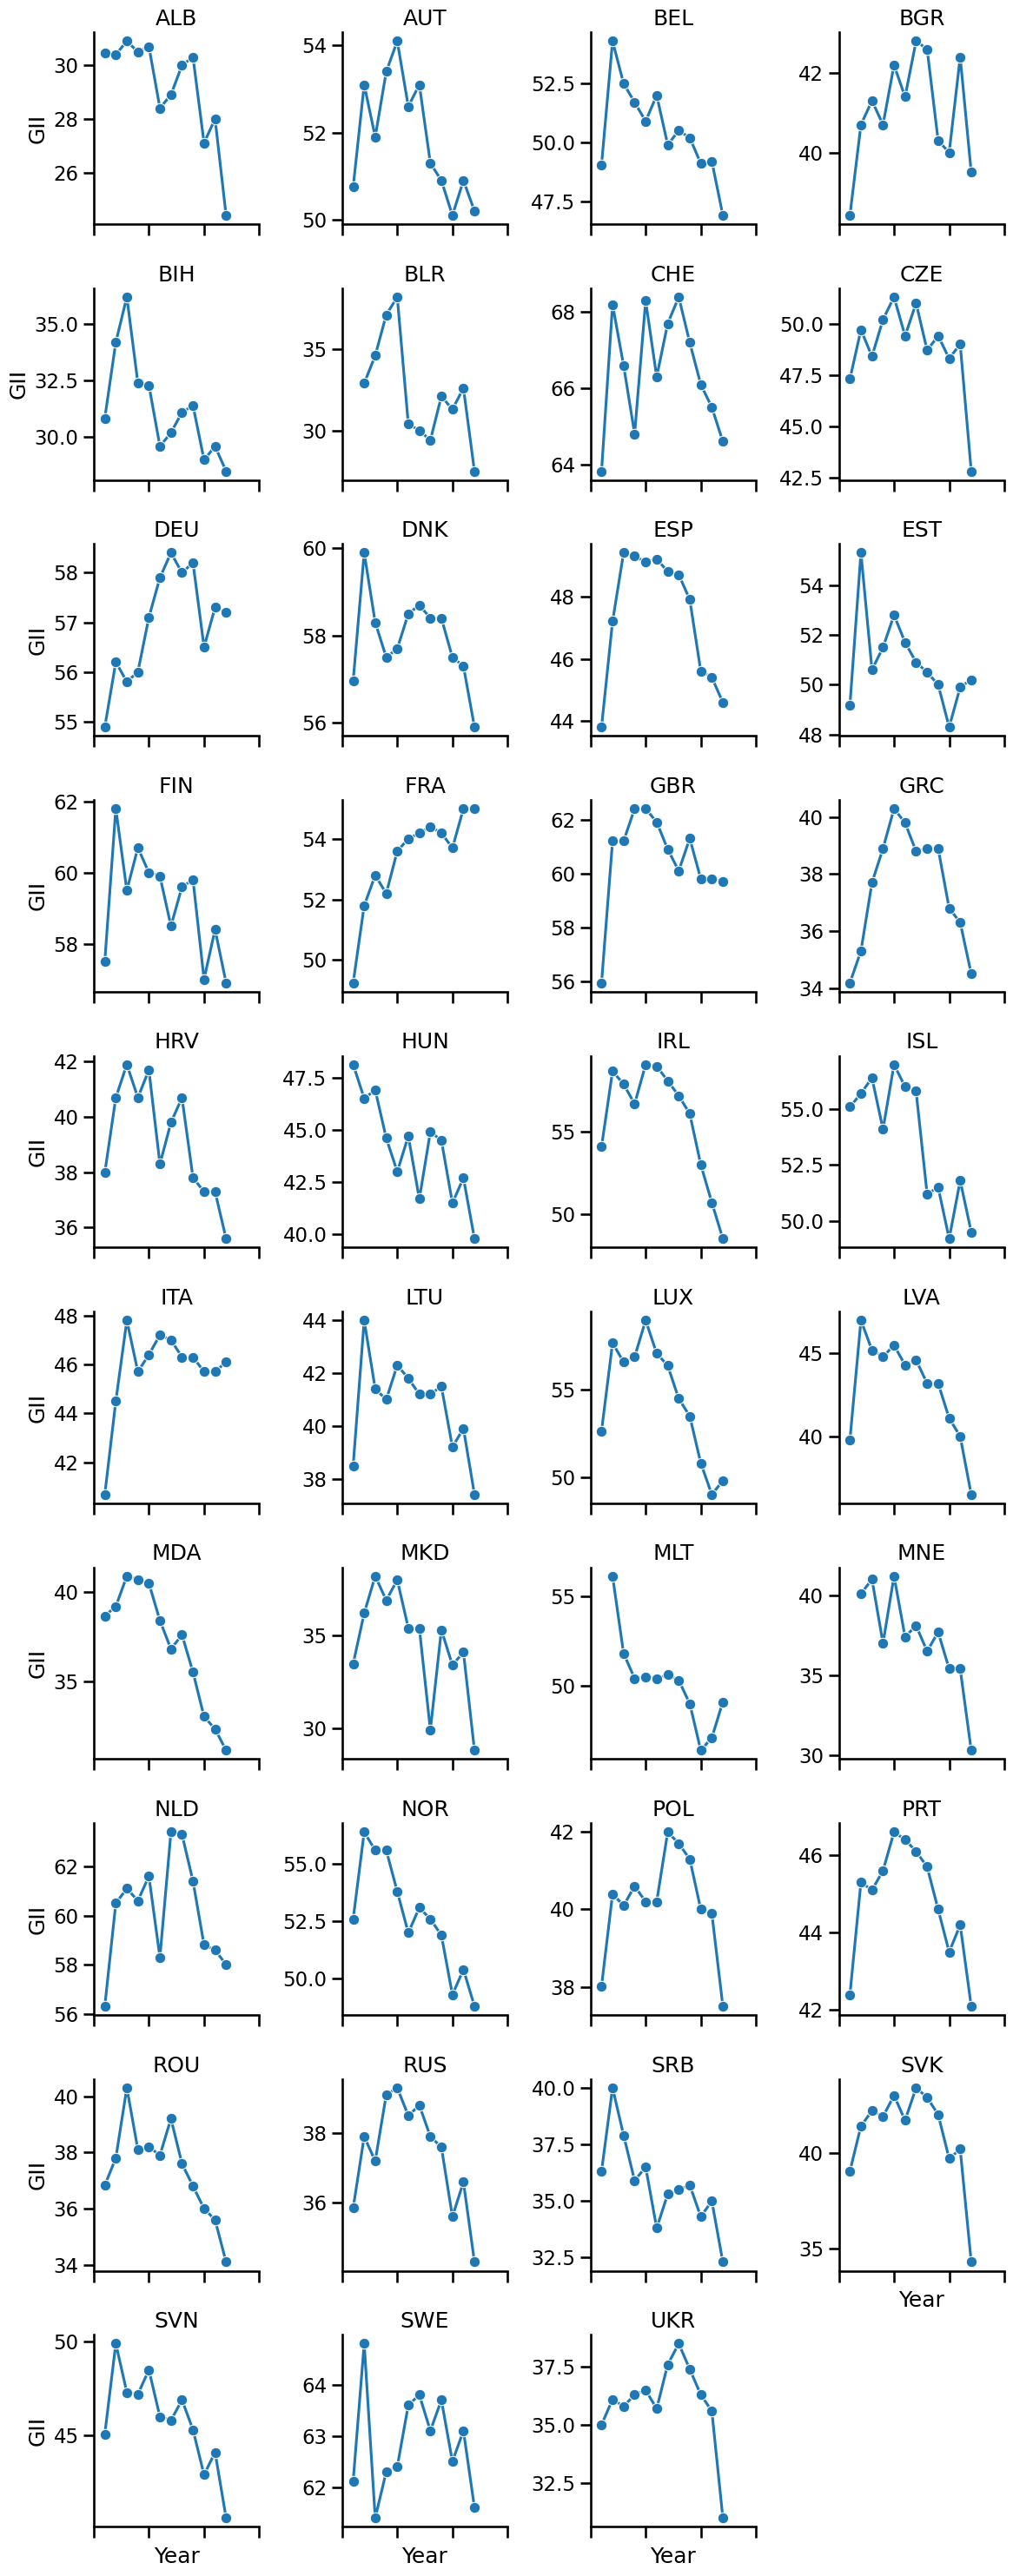

In [52]:
# For each row / country in the GII_historical dataframe plot the GII over the years
# The x-axis should be the years and the y-axis the GII
# The color of the line should be the country
# The title should be the country
# The x-axis label should be the years

import matplotlib.pyplot as plt
import seaborn as sns
#
g = sns.FacetGrid(GII_melted, col="ISO3", col_wrap=4, height=3, sharey=False)
g.map(sns.lineplot, "Year", "Global Innovation Index", marker="o")

# Customize the plot
g.set_titles("{col_name}")
g.set_axis_labels("Year", "GII")
g.set_xticklabels(rotation=45)
g.tight_layout()
plt.show()


## Calculate Dervatives

Next we calculate the derivatives of the GII data to see if we can find some interesting patterns. Maybe with those we can predict future innovation levels.

In [53]:
# Calculate first and second derivatives
derivatives = GII_historical.copy()

# First derivative (rate of change)
first_derivative = derivatives.diff(axis=1)
print(first_derivative.head())

# Second derivative (acceleration)
second_derivative = first_derivative.diff(axis=1)
print(second_derivative.head())



Year  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
ISO3                                                                        
ALB    NaN -0.05   0.5  -0.4   0.2  -2.3   0.5   1.1   0.3  -3.2   0.9  -3.6
AUT    NaN  2.35  -1.2   1.5   0.7  -1.5   0.5  -1.8  -0.4  -0.8   0.8  -0.7
BEL    NaN  5.25  -1.8  -0.8  -0.8   1.1  -2.1   0.6  -0.3  -1.1   0.1  -2.3
BGR    NaN  2.28   0.6  -0.6   1.5  -0.8   1.4  -0.2  -2.3  -0.3   2.4  -2.9
BIH    NaN  3.36   2.0  -3.8  -0.1  -2.7   0.6   0.9   0.3  -2.4   0.6  -1.1
Year  2011  2012  2013  2014          2015  2016  2017  2018  2019  2020  \
ISO3                                                                       
ALB    NaN   NaN  0.55  -0.9  6.000000e-01  -2.5   2.8   0.6  -0.8  -3.5   
AUT    NaN   NaN -3.55   2.7 -8.000000e-01  -2.2   2.0  -2.3   1.4  -0.4   
BEL    NaN   NaN -7.05   1.0 -7.105427e-15   1.9  -3.2   2.7  -0.9  -0.8   
BGR    NaN   NaN -1.68  -1.2  2.100000e+00  -2.3   2.2  -1.6  -2.1   2.0   
BIH  

In [54]:

gii_data_2023 = get_europe(GII_2023)

#print the column ISO3 and SCORE where the column NUM is null
pure_rank = gii_data_2023[gii_data_2023["NUM"].isnull()]
#do not display the rank only the score and ISO3
gii_scores_2023 = pure_rank.sort_values("SCORE")[["SCORE", "ISO3"]]
#rename SCORE to 2023
gii_scores_2023.rename(columns={"SCORE": "2023"}, inplace=True)
print(gii_scores_2023.head())

            2023 ISO3
0      25.426758  ALB
1110   26.843908  BLR
1554   27.148722  BIH
8658   27.796063  MNE
11100  30.333934  MDA


## Trying to predict a trend of the GII scores with the help of the derivatives

Following the idea of the previous section, we will now try to build a simple model using only the derivatives of the GII data. We will see if we can predict future innovation levels with this model.

In [55]:
# now for each country we have the first and second derivative of the GII for the years 2011 to 2022
# we also got the GII scores for thhe year 2023
# now we can do following predictions if the first derivative is positive and the second derivative is negative
# the GII will still increase but at a slower rate
# if the first derivative is negative and the second derivative is positive the GII will decrease but at a slower rate
# if the first derivative is positive and the second derivative is positive the GII will increase at an increasing rate
# if the first derivative is negative and the second derivative is negative the GII will decrease at an increasing rate
# if the first derivative is positive and the second derivative is zero the GII will increase at a constant rate
# if the first derivative is negative and the second derivative is zero the GII will decrease at a constant rate
# if the first derivative is close to zero the GII will stay constant

# we got following dataframes 
# gii_scores_2023 , columns ISO3 and SCORE
# first_derivative, columns are the years, the rows are the countries
# second_derivative, columns are the years, the rows are the countries

# now we can calculate the predictions for the year 2023 and compare them with the actual scores
# the prediicitons are in following format. IO3, Increases/Decreases/Constant, Slower/Faster, Scorefrom 2022, Score from 2023, TRUE/FALSE IF CORRECT
gii_scores_2022 = GII_historical[2022]  
#print(gii_scores_2022)
gii_scores = pd.merge(gii_scores_2022, gii_scores_2023, on='ISO3', suffixes=('_2022', '_2023'))
gii_scores.set_index('ISO3', inplace=True)
#print(gii_scores)
results = []
for iso3 in gii_scores.index:
    # Extract derivatives for 2022
    try:
        fd = first_derivative.loc[iso3, 2022]
        sd = second_derivative.loc[iso3, 2022]
    except KeyError:
        print(f"Derivatives not available for {iso3}")
        continue
    
    # Determine trend and rate
    trend = "Constant"
    rate = "Constant"
    
    epsilon = 1  # Threshold for considering zero
    
    if abs(fd) < epsilon:
        trend = "Constant"
        rate = ""  # Rate not applicable if constant
    else:
        if fd > 0:
            trend = "Increases"
            if sd < -epsilon:
                rate = "Slower"
            elif sd > epsilon:
                rate = "Faster"
            else:
                rate = "Constant"
        else:
            trend = "Decreases"
            if sd > epsilon:
                rate = "Slower"
            elif sd < -epsilon:
                rate = "Faster"
            else:
                rate = "Constant"
    
    # Retrieve actual scores for 2022 and 2023
    score_row = gii_scores.loc[iso3]
    if score_row.empty:
        score_2022 = None
        score_2023 = None
    else:
        score_2022 = score_row.values[0]
        score_2023 = score_row.values[1]
        #round score_2023 to 1 decimal places   
        score_2023 = round(score_2023, 1)
    
    # Determine actual trend
    actual_trend = "Constant"
    if score_2022 is not None and score_2023 is not None:
        # Calculate the absolute difference between 2023 and 2022 scores
        difference = abs(score_2023 - score_2022)
        
        # Determine the trend based on the difference
        if difference <= 1:
            actual_trend = "Constant"
        elif score_2023 > score_2022:
            actual_trend = "Increases"
        else:
            actual_trend = "Decreases"
    
    # Check if prediction is correct
    correct = False
    if trend == "Constant":
        correct = (actual_trend == "Constant")
    else:
        correct = (trend == actual_trend)
        dumbPrediction = ("Increases" == actual_trend)
    
    #print(iso3, trend, rate, score_2022, score_2023, correct)
    # Append the result
    results.append({
        'ISO3': iso3,
        'Predicted Trend': trend,
        'first_derivative': fd,
        'second_derivative': sd,
        'Predicted Rate': rate,
        'Score 2022': score_2022,
        'Score 2023': score_2023,
        'Correct Prediction': correct,
        'Dumb Prediction': dumbPrediction
    })

# Create the results DataFrame
results_df = pd.DataFrame(results)
#display(results_df)
# calculate the accuracy of the predictions
accuracy = results_df["Correct Prediction"].mean()
print(f"Accuracy actual: {accuracy:.2f}")  

# calculate the accuracy of the dumb predictions
# where just the GII increases
accuracy = results_df["Dumb Prediction"].mean()
print(f"Accuracy dumb: {accuracy:.2f}")


Accuracy actual: 0.13
Accuracy dumb: 0.64


Very bad model only 0.13 accuracy for the predictions on the year 2023. This is not a good model. The dumb model with only predicting a increase would score way better.

## Arima model using previous GII data

Next we train an ARIMA model using the previous GII data to see if we can predict future innovation levels.

In [56]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

def forecast_gii(series, order=(1,1,1)):
    """Fit ARIMA model and return forecasted value."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Suppress warnings
        try:
            model = ARIMA(series, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)
            return forecast.iloc[0]
        except:
            return None  # Handle cases where model fails

# Store predictions in a dictionary
predictions = {}
def train_arima(series, order=(1,1,1)):  
    for iso3, data in series.iterrows():
        # Convert row to a time series (data is already ordered by year)
        ts = data.astype(float)
        # Handle missing values via interpolation
        ts = ts.interpolate()
        # Get forecast
        forecast = forecast_gii(ts, order)
        predictions[iso3] = forecast

    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame.from_dict(
        predictions, 
        orient='index', 
        columns=['Predicted_GII']
    )
    return predictions_df

In [57]:

arima_order_values = [(1,1,1), (2,1,1), (1,1,2), (2,1,2)]


for tuple in arima_order_values:
    print(f"ARIMA order: {tuple}")
    # We now got predictions for the GII for the year 2023. With the actual GII scores for the year 2023 we can now calculate the accuracy of the predictions
    # The predictions are in the column Predicted_GII
    # The actual scores are in the column 2023 in dataframe gii_data_2023 
    gii_gt = gii_scores_2023.set_index('ISO3')
    #print(gii_gt.head())
    # Merge the predictions with the actual scores
    predictions_df = train_arima(GII_historical, tuple)
    results = pd.merge(predictions_df, gii_gt, left_index=True, right_index=True)
    # add also the data from the year 2022
    results = pd.merge(results,gii_scores_2022, left_index=True, right_index=True)
    results.rename(columns={"2023": "Actual_GII"}, inplace=True)
    #print(results.head())

    # Calculate the accuracy of the predictions
    # Calcualte the absoulute error between each prediction and the actual score
    results["Error"] = results["Predicted_GII"] - results["Actual_GII"]
    results["Squared Error"] = results["Error"] ** 2
    # Calculate the mean absolute error
    mae = results["Error"].abs().mean()
    print(f"MAE between predicted and actual GII: {mae:.2f}")
    RMSE = results["Squared Error"].mean() ** 0.5
    print(f"RMSE between predicted and actual GII: {RMSE:.2f}")

# lets see what the mae would be if just reusing the score from 2022
results["Error22"] = results[2022] - results["Actual_GII"]
mae = results["Error22"].abs().mean()
print(f"MAE between 2022 and actual GII: {mae:.2f}")
RMSE = results["Error22"] ** 2  
RMSE = RMSE.mean() ** 0.5
print(f"RMSE between 2022 and actual GII: {RMSE:.2f}")

ARIMA order: (1, 1, 1)
MAE between predicted and actual GII: 1.74
RMSE between predicted and actual GII: 2.14
ARIMA order: (2, 1, 1)
MAE between predicted and actual GII: 1.72
RMSE between predicted and actual GII: 2.10
ARIMA order: (1, 1, 2)
MAE between predicted and actual GII: 1.94
RMSE between predicted and actual GII: 2.34
ARIMA order: (2, 1, 2)
MAE between predicted and actual GII: 1.65
RMSE between predicted and actual GII: 2.11
MAE between 2022 and actual GII: 1.92
RMSE between 2022 and actual GII: 2.24


Top shows a the results of the ARIMA model with different order parameters. The best model had a MAE of 1.72 which is better than just predicting the previous year values. But still not a good model.
This could be due the fact that the historical data is only from 2011 to 2022. The GII score calculation also changed over the years which makes trend prediction/forecasting with historical data difficult.

# Conclusion


# Work distribution